<h2 style='text-align: center;'>ID6002W:Online and Reinforcement Learning</h2>
<h3 style='text-align: center;'>Assignment 2 - Q1</h3>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

#### With 10000 Iteration

#### Importing Library

In [1]:
import gym
from gym import spaces
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm
import time

In [2]:
np.random.seed(15)

In [3]:
start_time = time.time()

#### Common Function

In [1]:
def plot_reward_steps(avg_reward, steps, episodes, algorithm_name, goal):
    """
    Plot the average reward and number of steps per episode for a given algorithm.
    
    Parameters:
        avg_reward (list): A list of average reward values for each episode.
        steps (list): A list of number of steps for each episode.
        episodes (int): The total number of episodes.
        algorithm_name (str): The name of the algorithm to be displayed in the plot titles.
    """

    # Colors for different values of epsilon
    colors = ['g', 'r', 'k', 'b', 'y', 'm', 'c']

    # Creating a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plotting average reward
    ax1.plot(range(episodes), avg_reward, color=random.choice(colors), marker='o', linestyle='-', linewidth=2, label="Average reward")
    # Setting title, x-label and y-label for the subplot
    ax1.set_title(f'{algorithm_name} - Average Reward', fontsize=16)
    ax1.set_xlabel('Episodes', fontsize=14)
    ax1.set_ylabel('Average Reward', fontsize=14)
    # Displaying legend
    ax1.legend(loc="upper left")

    # Plotting number of steps
    ax2.plot(range(episodes), steps, color=random.choice(colors), marker='o', linestyle='-', linewidth=2, label="Steps")
    # Setting title, x-label and y-label for the subplot
    ax2.set_title(f'{algorithm_name} - Number of Steps', fontsize=16)
    ax2.set_xlabel('Episodes', fontsize=14)
    ax2.set_ylabel('Steps', fontsize=14)
    # Displaying legend
    ax2.legend(loc="upper right")

    # Adding super title for the entire figure
    fig.suptitle(f'{algorithm_name} - Learning Performance - for :{goal}', fontsize=20)

    # Displaying the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.90) # To ensure that the suptitle doesn't overlap with the subplot titles
    plt.show()   

def plot_policy(goal_pos, policy_matrix):
    """
    Plot the policy learned by the agent.

    Parameters:
        goal_pos (list): The position of the goal in the environment (format: [x, y]).
        policy_matrix (numpy.ndarray): The policy matrix representing the agent's actions at each state.
    """
    
    plt.rcParams['figure.figsize'] = [7, 7]
    fig, ax = plt.subplots()
    colors = ['#279259', '#00FF7F', '#00ff00', '#15B01A']
    random_colors = random.sample(colors, 4)

    # Define a custom color map for the policy plot     
    cmap = mcolors.ListedColormap(random_colors)
    # Display the policy matrix as a heatmap with the custom color map
    ax.matshow(policy_matrix, cmap=cmap)

    # Customize font size and colors for better readability
    for i in range(policy_matrix.shape[1]):
        for j in range(policy_matrix.shape[0]):
            if [j, i] == goal_pos:  # Check if the current cell is the goal position
                ax.text(i, j, 'G', va='center', ha='center', fontsize=16, fontweight='bold', color='black')  # Display 'G' for the goal position
            else:
                c = int(policy_matrix[j, i])  # Get the action index at the current state
                directions = {0: '↑', 1: '→', 2: '←', 3: '↓'}  # Map action index to direction symbols
                ax.text(i, j, directions[c], va='center', ha='center', fontsize=14, color='white')  # Display the corresponding direction symbol

    # Set the title and labels
    ax.set_title(f"Policy Matrix - Goal Position: {goal_pos}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Hide the axis ticks and labels for a cleaner plot
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a colorbar for the action directions
    cbar = plt.colorbar(ax.matshow(policy_matrix, cmap=cmap), ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['↑', '→', '←', '↓'])

    # Show the plot
    plt.show() 

#### Puddle World Environment Creation

In [5]:
class PuddleWorld():
    """
    Puddle World Environment.

    This class implements the Puddle World environment, which is a grid world with puddles and goals.
    The agent can take actions to move in four directions: up, down, left, and right.
    The agent's goal is to reach one of the three goal positions while avoiding the puddles.
    The environment can be stochastic, where some actions may have a chance of failure or wind pushing the agent.

    The grid is represented by a 12x12 numpy array with each cell having a reward value. The rewards for puddles,
    walls, and goals are pre-defined. The agent's starting position can be randomly chosen from a set of start positions.
    The goal positions have different wind conditions (enabled or disabled).

    The allowed actions are:
    0: Up
    1: Right
    2: Left
    3: Down

    The observation space is represented as a Box with values ranging from -3 to 10, indicating different rewards.

    Attributes:
        grid (numpy.ndarray): The grid representing the environment with reward values for each cell.
        goal_positions (list): List of goal positions, where each goal is represented as [x, y].
        actions (dict): Dictionary of allowed actions with keys as action indices and values as action deltas [dx, dy].
        action_space (gym.spaces.Discrete): The action space representing the number of possible actions.
        observation_space (gym.spaces.Box): The observation space representing the reward values of cells.
        wind (int): Flag to indicate if wind is enabled (1) or disabled (0).
        push (int): Flag to indicate if wind pushes the agent eastward (1) or not (0).

    """

    
    metadata = {'render.modes': ['human']}
    def __init__(self):
        """
        Initialize the Puddle World environment.

        The grid is initialized as a 12x12 numpy array with zeros for all cells.
        The rewards for puddles, walls, and goals are set in the grid.

        """
        # Initialize the grid world
        self.grid = np.zeros([12, 12], dtype=np.int64)

        # Set rewards for the puddle        
        # Reward -1       
        self.grid[2,3] = -1
        self.grid[3,3] = -1
        self.grid[4,3] = -1
        self.grid[5,3] = -1
        self.grid[6,3] = -1
        self.grid[7,3] = -1
        self.grid[8,3] = -1
        self.grid[8,4] = -1
        self.grid[8,5] = -1
        self.grid[8,6] = -1
        self.grid[8,7] = -1
        self.grid[7,7] = -1
        self.grid[6,7] = -1
        self.grid[3,8] = -1
        self.grid[4,8] = -1
        self.grid[5,8] = -1
        self.grid[6,8] = -1
        self.grid[2,4] = -1
        self.grid[2,5] = -1
        self.grid[2,6] = -1
        self.grid[2,7] = -1
        self.grid[2,8] = -1        
        # Reward -2
        self.grid[3,4] = -2
        self.grid[3,5] = -2
        self.grid[3,6] = -2
        self.grid[3,7] = -2
        self.grid[4,4] = -2
        self.grid[5,4] = -2
        self.grid[6,4] = -2
        self.grid[7,4] = -2
        self.grid[7,5] = -2
        self.grid[7,6] = -2
        self.grid[6,6] = -2
        self.grid[5,6] = -2
        self.grid[4,7] = -2
        self.grid[5,7] = -2        
        # Reward -3
        self.grid[4,5] = -3
        self.grid[4,6] = -3
        self.grid[5,5] = -3
        self.grid[6,5] = -3
        
        # Goal positions A, B, C
        self.goal_positions = [[0, 11], [2, 9], [6, 7]]

        # Allowed actions
        # Our origin is on the top left corner
        self.actions = {0:[-1, 0], 1:[0, 1], 2:[0, -1], 3:[1, 0]}

        # All actions
        self.action_space = spaces.Discrete(len(self.actions))
        # All states
        self.observation_space = spaces.Box(low=-3, high=10, shape=self.grid.shape)

        # Initialize reward
        self.reward, self.wind, self.push = 0, 0, 0

    def get_start_positions(self):
        """
        Return possible start positions.

        Returns:
            list: List of start positions, where each start position is represented as [x, y].

        """
        start_positions = [[5, 0], [6, 0], [10, 0], [11, 0]]
        return start_positions

    def set_goal(self, goal):
        """
        Set the goal position and enable/disable wind for different goals.

        Args:
            goal (str): The goal name ('A', 'B', or 'C').

        Returns:
            tuple: Tuple containing the goal position (x, y) and wind status (1 for enabled, 0 for disabled).

        """
        if goal == 'A':
            x, y = self.goal_positions[0]
            self.grid[x, y] = 10
            self.wind = 1
            return self.goal_positions[0]
        elif goal == 'B':
            x, y = self.goal_positions[1]
            self.grid[x, y] = 10
            self.wind = 1
            return self.goal_positions[1]
        elif goal == 'C':
            x, y = self.goal_positions[2]
            self.grid[x, y] = 10
            self.wind = 0
            return self.goal_positions[2]

    def get_reward(self, position):
        """
        Return the reward for being in the current state.

        Args:
            position (list): The current position [x, y].

        Returns:
            int: The reward value for the current state.

        """
        # The values of the matrix contain the reward of transitioning into that state
        self.reward = self.grid[position[0], position[1]]
        return self.reward

    def actual_action(self, selected_action):
        """
        Return the action after considering the stochastic nature of actions.

        Args:
            selected_action (int): The selected action index.

        Returns:
            int: The action index after considering stochasticity.

        """
        # Set the probabilities of performing an action
        probs = [0.1 / 3, 0.1 / 3, 0.1 / 3, 0.1 / 3]
        probs[selected_action] = 0.9
        # Select an action according to probabilities
        direction = np.random.choice([0, 1, 2, 3], 1, p=probs)
        direction = direction[0]
        return direction

    def random_action(self):
        """
        Pick a random action.

        Returns:
            int: The index of the randomly chosen action.

        """
        self.action = np.random.choice([0, 1, 2, 3])
        return self.action

    def step(self, curr_state, action):
        """
        Return the next state and reward after performing an action.

        Args:
            curr_state (list): The current state [x, y].
            action (int): The action index.

        Returns:
            tuple: Tuple containing the next state [x, y] and the reward for the action.

        """
        # Return the position, reward after performing an action.
        # Select the action by considering stochastic nature after selecting an action
        action = self.actual_action(action)

        if self.wind:
            # Westerly blowing, that will push you one additional cell to the east with probability of 0.5
            self.push = np.random.choice(range(2), 1, [0.5, 0.5])
            self.push = self.push[0]
        else:
            self.push = 0

        # According to the action taken, return the reward and the next state
        if (
            curr_state[0] + self.actions[action][0] < 0
            or curr_state[0] + self.actions[action][0] > 11
            or curr_state[1] + self.actions[action][1] + self.push < 0
            or curr_state[1] + self.actions[action][1] + self.push > 11
        ):
            # Transitions that take you off the grid will not result in any change
            self.reward = self.get_reward(curr_state)
            next_state = curr_state
            return next_state, self.reward
        else:
            x = curr_state[0] + self.actions[action][0]
            y = curr_state[1] + self.actions[action][1] + self.push
            next_state = [x, y]
            self.reward = self.get_reward(next_state)
            return next_state, self.reward

    def reset(self):
        """
        Bring our agent back to one of the start states.

        Returns:
            list: The starting state [x, y].

        """
        # Select a random start state
        idx = np.random.choice([0, 1, 2, 3])
        start_positions = self.get_start_positions()
        self.pos = start_positions[idx]
        return self.pos    

### Alogorithm Implementation

#### Q-learning Algorithm

In [6]:
class QLearning:

    def update_rule(self, state, action, reward, next_state, Q, learning_rate, discount_factor):
        """
        Update Q-values using Q-Learning update rule.

        Parameters:
            state (tuple): Current state.
            action (int): Action taken in the current state.
            reward (float): Reward obtained after taking the action.
            next_state (tuple): Next state reached after taking the action.
            Q (numpy.ndarray): Q-values table.
            learning_rate (float): Learning rate (alpha) for Q-Learning update.
            discount_factor (float): Discount factor (gamma) for future rewards.

        Returns:
            numpy.ndarray: Updated Q-values table.
        """

        Q[state[0], state[1], action] = (1.0 - learning_rate) * Q[state[0], state[1], action] + learning_rate * (reward + discount_factor * np.max(Q[next_state[0], next_state[1], :]))
        return Q

    def pick_action(self, state, Q, epsilon):
        """
        Select an action using epsilon-greedy strategy.

        Parameters:
            state (tuple): Current state.
            Q (numpy.ndarray): Q-values table.
            epsilon (float): Exploration probability.

        Returns:
            int: The index of the selected action.
        """

        rand = np.random.uniform(0, 1)
        if rand < epsilon:
            action_index = np.random.choice(Q.shape[2])
        else:
            action_index = np.argmax(Q[state[0], state[1], :])
        return action_index

    def episode_run(self, discount_factor, learning_rate, exploration_prob, num_episodes, env, goal):
        """
        Sample trajectories and run Q-Learning.

        Parameters:
            discount_factor (float): Discount factor (gamma) for future rewards.
            learning_rate (float): Learning rate (alpha) for Q-Learning update.
            exploration_prob (float): Probability of exploration (epsilon) for epsilon-greedy strategy.
            num_episodes (int): Number of episodes to run Q-Learning.
            env (gym.Env): The environment for Q-Learning.
            goal (str): The goal identifier for the environment.

        Returns:
            numpy.ndarray: Array containing average rewards obtained in each episode.
            numpy.ndarray: Array containing the number of steps taken in each episode.
            numpy.ndarray: Updated Q-values table.
        """

        rewards, num_steps, episode_data = [], [], []
        steps, avg_reward = np.zeros(num_episodes), np.zeros(num_episodes)
        # Target
        goal_pos = env.set_goal(goal)
        # Random initialization
        Q = np.random.rand(env.observation_space.shape[0], env.observation_space.shape[1], env.action_space.n)
        for episode in tqdm(range(num_episodes)):
            # Initialize the start state
            curr_state = env.reset()
            ep_reward, num_step = 0, 0
            while True:
                # Pick an action and apply it to go to the next state
                curr_action = self.pick_action(curr_state, Q, exploration_prob)
                next_state, reward = env.step(curr_state, curr_action)
                # Update Q-values based on the update rule
                Q = self.update_rule(curr_state, curr_action, reward, next_state, Q, learning_rate, discount_factor)
                curr_state = next_state
                num_step += 1
                ep_reward += reward
                steps[episode] += 1
                avg_reward[episode] += reward
                if curr_state == goal_pos:
                    break
            rewards.append(ep_reward)
            num_steps.append(num_step)
            episode_data.append([episode + 1, ep_reward, num_step])

        print("-----------All episodes done-----------")
        print(f"Episode {episode + 1}: Total reward = {avg_reward[episode]}, Number of steps = {steps[episode]}")
        episode_df = pd.DataFrame(episode_data, columns=["Episode", "Total Reward", "Number of Steps"])
        display(episode_df)
        return avg_reward, steps, Q     

__Sarsa Algorithm__


In [7]:
class SARSA:
    
    def update_rule(self, curr_state, curr_action, reward, next_state, next_action, Q, alpha, gamma):
        """
        Update the Q-values using the SARSA update rule.

        Parameters:
            curr_state (tuple): Current state.
            curr_action (int): Action taken in the current state.
            reward (float): Reward obtained after taking the current action.
            next_state (tuple): Next state reached after taking the current action.
            next_action (int): Action taken in the next state.
            Q (numpy.ndarray): Q-values table.
            alpha (float): Learning rate (step size) for the update rule.
            gamma (float): Discount factor for future rewards.

        Returns:
            numpy.ndarray: Updated Q-values table.
        """

        # Calculate the temporal difference error
        error = reward + (gamma * Q[next_action][next_state[0], next_state[1]]) - Q[curr_action][curr_state[0], curr_state[1]]
        # Update Q-value for the current state-action pair
        Q[curr_action][curr_state[0], curr_state[1]] += alpha * error
        return Q
    
    
    def pick_action(self, epsilon, state, Q, env):
        """
        Select an action using epsilon-greedy strategy.

        Parameters:
            epsilon (float): Exploration probability.
            state (tuple): Current state.
            Q (numpy.ndarray): Q-values table.
            env (PdwEnv): The environment.

        Returns:
            int: The index of the selected action.
        """

        if np.random.uniform(0, 1) < epsilon:
            # Randomly choose an action with probability epsilon
            action = env.random_action()
        else:
            # Choose the action with the highest Q-value for the current state
            action = np.argmax(Q[:, state[0], state[1]])

        return action
    
    
    def episode_run(self, gamma, alpha, epsilon, episodes, env, goal):
        """
        Run SARSA algorithm to learn the optimal policy.

        Parameters:
            gamma (float): Discount factor for future rewards.
            alpha (float): Learning rate (step size) for the update rule.
            epsilon (float): Probability of exploration for epsilon-greedy strategy.
            episodes (int): Number of episodes to run SARSA.
            env (PdwEnv): The environment for SARSA.
            goal (str): The goal identifier for the environment.

        Returns:
            numpy.ndarray: Array containing average rewards obtained in each episode.
            numpy.ndarray: Array containing the number of steps taken in each episode.
            numpy.ndarray: Updated Q-values table.
        """
        episode_data = []
        # Initialize Q-values table with random values
        Q = np.random.rand(env.action_space.n, env.observation_space.shape[0], env.observation_space.shape[1])
        # Set the goal position and terminal state
        goal_pos = env.set_goal(goal)
        # Arrays to store average rewards and steps per episode
        steps = np.zeros(episodes)
        avg_reward = np.zeros(episodes)
        for episode in tqdm(range(episodes)):
            # Reset the environment to start a new episode
            curr_state = env.reset()
            curr_action = self.pick_action(epsilon, curr_state, Q, env)
            while True:
                # Take an action and observe the next state and reward
                next_state, reward = env.step(curr_state, curr_action)
                next_action = self.pick_action(epsilon, next_state, Q, env)
                # Update Q-values based on the SARSA update rule
                Q = self.update_rule(curr_state, curr_action, reward, next_state, next_action, Q, alpha, gamma)
                curr_state = next_state
                curr_action = next_action
                # Update the episode statistics
                steps[episode] += 1
                avg_reward[episode] += reward
                if curr_state == goal_pos:
                    break
            episode_data.append([episode + 1, avg_reward, steps[episode]])
        
        print("-----------All episodes done-----------")
        print(f"Episode {episode + 1}: Total reward = {avg_reward[episode]}, Number of steps = {steps[episode]}")
        episode_df = pd.DataFrame(episode_data, columns=["Episode", "Avg Reward", "Number of Steps"])
        display(episode_df)
        return avg_reward, steps, Q       

#### Common variable declaration

In [8]:
env = PuddleWorld()
goal_positions = {'A': [0, 11], 'B': [2, 9], 'C': [6, 7]}
gamma, alpha, epsilon, episodes, independent_run = 0.9, 0.1, 0.1, 10000, 50
algo_object_QLearning = QLearning() 
algo_object_SARSA = SARSA()
QLearning_axis = -1
SARSA_axis = 0

### Q - Learning execution for each goal

100%|██████████| 10000/10000 [00:17<00:00, 576.20it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1           -13             2675
1           2            -5             1728
2           3             4              836
3           4             1              209
4           5             4              166
...       ...           ...              ...
9995     9996            10               28
9996     9997            10               27
9997     9998             9               13
9998     9999            10               23
9999    10000             9               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:20<00:00, 496.33it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0           1            -3              477
1           2            -8              317
2           3             5              286
3           4           -12              201
4           5             5              213
...       ...           ...              ...
9995     9996             3               12
9996     9997            10               19
9997     9998            10               32
9998     9999            10               22
9999    10000            10               30

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 540.48it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1             6             2971
1           2            10              320
2           3             0               90
3           4            10              195
4           5            10              353
...       ...           ...              ...
9995     9996            10               51
9996     9997            10               28
9997     9998            10               28
9998     9999             8               12
9999    10000             8               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:21<00:00, 464.47it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1            -1              189
1           2            -1               47
2           3            -8               31
3           4            10              410
4           5             3              273
...       ...           ...              ...
9995     9996            10               32
9996     9997            10               34
9997     9998            10               19
9998     9999             9               36
9999    10000             8               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 541.59it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 34.0


Episode  Total Reward  Number of Steps
0           1           -68             4985
1           2             8              420
2           3             7              250
3           4           -18               55
4           5             7              364
...       ...           ...              ...
9995     9996             6               10
9996     9997             8               15
9997     9998            10               18
9998     9999             9               11
9999    10000            10               34

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 554.91it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1            -2              383
1           2             1              135
2           3            10              307
3           4            -8               54
4           5            -5              514
...       ...           ...              ...
9995     9996            10               25
9996     9997            10               25
9997     9998            10               26
9998     9999            10               27
9999    10000            10               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 544.57it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0           1             4              338
1           2            -6              108
2           3             7              235
3           4           -16               73
4           5            10              212
...       ...           ...              ...
9995     9996             9               12
9996     9997            10               18
9997     9998            10               11
9998     9999            10               24
9999    10000            10               31

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 583.46it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0           1             9              253
1           2             9              271
2           3            -7              277
3           4             7              228
4           5             8              102
...       ...           ...              ...
9995     9996            10               17
9996     9997            10               25
9997     9998             8               15
9998     9999             4               20
9999    10000            10               26

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 567.63it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1             6              319
1           2           -11              650
2           3             1              349
3           4            -4             1107
4           5             9              410
...       ...           ...              ...
9995     9996            10               30
9996     9997            10               18
9997     9998            10               29
9998     9999            10               15
9999    10000            10               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 557.56it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 43.0


Episode  Total Reward  Number of Steps
0           1           -11              474
1           2            -2              143
2           3             1               16
3           4             9              343
4           5           -14              108
...       ...           ...              ...
9995     9996             7               13
9996     9997            10               27
9997     9998             8               16
9998     9999             9               12
9999    10000            10               43

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 545.78it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0           1           -12              622
1           2             5              206
2           3           -19              565
3           4           -13               30
4           5             4              285
...       ...           ...              ...
9995     9996            10               16
9996     9997            10               20
9997     9998            10               22
9998     9999            10               13
9999    10000            10               26

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 576.87it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1             2              619
1           2            10              395
2           3            10              241
3           4             9              454
4           5             1              212
...       ...           ...              ...
9995     9996            10               14
9996     9997            10               29
9997     9998             9               12
9998     9999            10               32
9999    10000            10               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 552.79it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1          -113             1586
1           2           -16              533
2           3             7              337
3           4            10              372
4           5             2              510
...       ...           ...              ...
9995     9996            10               32
9996     9997            10               13
9997     9998            10               31
9998     9999            10               38
9999    10000             9               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 519.94it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1           -34              297
1           2             1             2128
2           3             2              658
3           4            -9              123
4           5           -13              229
...       ...           ...              ...
9995     9996            10               18
9996     9997            10               32
9997     9998            10               42
9998     9999            10               29
9999    10000            10               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 550.05it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1            -5             1858
1           2            -1               28
2           3           -23              473
3           4            10              138
4           5           -16               28
...       ...           ...              ...
9995     9996            10               14
9996     9997            10               15
9997     9998             7               18
9998     9999            10               16
9999    10000             8               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 542.30it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0           1           -14             1889
1           2           -24             3548
2           3             0              823
3           4            -4              296
4           5           -12               37
...       ...           ...              ...
9995     9996            10               12
9996     9997            10               23
9997     9998            10               12
9998     9999            10               34
9999    10000            10               20

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 562.39it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1           -24             1643
1           2           -13             1461
2           3             6              300
3           4             7              284
4           5            10               90
...       ...           ...              ...
9995     9996            10               32
9996     9997            10               22
9997     9998            10               22
9998     9999            10               17
9999    10000            10               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 558.85it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 12.0


Episode  Total Reward  Number of Steps
0           1           -14              320
1           2           -22              912
2           3            -4             2616
3           4           -11              114
4           5            -2               47
...       ...           ...              ...
9995     9996            10               13
9996     9997            10               12
9997     9998            10               26
9998     9999             8               15
9999    10000             9               12

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 554.77it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1           -20             1110
1           2            -1              992
2           3             5              118
3           4             4              391
4           5            -3               51
...       ...           ...              ...
9995     9996            10               27
9996     9997             8               10
9997     9998            10               29
9998     9999            10               38
9999    10000             6               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 552.06it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1           -12             2745
1           2           -26             1109
2           3             2              361
3           4             6              306
4           5           -21              150
...       ...           ...              ...
9995     9996            10               18
9996     9997            10               10
9997     9998            10               34
9998     9999            10               20
9999    10000            10               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 577.13it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1             4              765
1           2           -20              149
2           3             8               69
3           4             3              285
4           5           -13              284
...       ...           ...              ...
9995     9996            10               17
9996     9997            10               18
9997     9998            10               19
9998     9999            10               20
9999    10000            10               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 539.32it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0           1           -13              113
1           2            -6              329
2           3            10              396
3           4             1              255
4           5            10              327
...       ...           ...              ...
9995     9996             8               20
9996     9997             9               18
9997     9998            10               30
9998     9999             4               23
9999    10000            10               20

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 559.96it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1           -10              562
1           2            -5              216
2           3            10              623
3           4            10              277
4           5            10              283
...       ...           ...              ...
9995     9996             9               13
9996     9997            10               23
9997     9998            10               13
9998     9999            10               12
9999    10000             8               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 587.66it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1             0              843
1           2           -19               49
2           3             1              357
3           4            10              138
4           5             7              131
...       ...           ...              ...
9995     9996             7               16
9996     9997            10               12
9997     9998            10               15
9998     9999            10               18
9999    10000            10               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 544.02it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 37.0


Episode  Total Reward  Number of Steps
0           1           -19             4347
1           2           -20              625
2           3           -17             2383
3           4           -16               69
4           5             2              180
...       ...           ...              ...
9995     9996            10               37
9996     9997            10               16
9997     9998             9               13
9998     9999            10               22
9999    10000            10               37

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 537.40it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1           -22             1958
1           2            -2              641
2           3             5              230
3           4            10              218
4           5           -42              576
...       ...           ...              ...
9995     9996            10               33
9996     9997            10               19
9997     9998            10               13
9998     9999            10               25
9999    10000            10               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 550.04it/s]

-----------All episodes done-----------
Episode 10000: Total reward = -1.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1            -2             1456
1           2           -21             3454
2           3            10              447
3           4             8              145
4           5             0              691
...       ...           ...              ...
9995     9996            10               12
9996     9997             8               12
9997     9998            10               33
9998     9999            10               33
9999    10000            -1               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 559.62it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0           1           -29              108
1           2           -18               66
2           3           -19               92
3           4            10               71
4           5           -23               49
...       ...           ...              ...
9995     9996            10               39
9996     9997             9               13
9997     9998            10               14
9998     9999             9               16
9999    10000            10               25

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 550.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1           -33              914
1           2           -12              667
2           3           -25              240
3           4            -5               54
4           5            10              149
...       ...           ...              ...
9995     9996            10               26
9996     9997            10               38
9997     9998            10               21
9998     9999             9               10
9999    10000            10               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 549.96it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0           1           -22             1084
1           2           -25               82
2           3            -6               61
3           4            -4               51
4           5           -27              621
...       ...           ...              ...
9995     9996            10               25
9996     9997             4               17
9997     9998            10               23
9998     9999             9                8
9999    10000            10               11

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 557.38it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0           1            -9              340
1           2           -46              128
2           3            10              123
3           4             6              105
4           5             2              258
...       ...           ...              ...
9995     9996             8               14
9996     9997            10               25
9997     9998            10               29
9998     9999            10               16
9999    10000            10               24

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 569.54it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 1.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0           1           -33               77
1           2            -5             1916
2           3            10              102
3           4             1               17
4           5            -3               72
...       ...           ...              ...
9995     9996            10               27
9996     9997            10               13
9997     9998            10               29
9998     9999            10               23
9999    10000             1               11

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 568.56it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 39.0


Episode  Total Reward  Number of Steps
0           1            -4              143
1           2             9               83
2           3           -10               69
3           4            -7               43
4           5            -5               43
...       ...           ...              ...
9995     9996            10               26
9996     9997            10               30
9997     9998            10               30
9998     9999            10               21
9999    10000            10               39

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 579.28it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0           1           -14             1440
1           2            -4               36
2           3             4               21
3           4             6              277
4           5            -7              252
...       ...           ...              ...
9995     9996            10               26
9996     9997            10               17
9997     9998             9               12
9998     9999             9               12
9999    10000            10               24

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 570.54it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0           1           -13             1485
1           2            -1              243
2           3           -12              178
3           4            10              229
4           5           -16              115
...       ...           ...              ...
9995     9996            10               30
9996     9997             5               27
9997     9998            10               36
9998     9999             8               13
9999    10000            10               28

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 584.78it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1           -14              360
1           2            10              104
2           3           -10              374
3           4           -23              167
4           5            10              368
...       ...           ...              ...
9995     9996            10               38
9996     9997            10               34
9997     9998            10               11
9998     9999             6               21
9999    10000            10               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:20<00:00, 485.83it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1             9              495
1           2            -7             3327
2           3             5              470
3           4             4               37
4           5             0               34
...       ...           ...              ...
9995     9996            10               24
9996     9997             8               14
9997     9998            10               12
9998     9999            10               39
9999    10000            10               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 546.15it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1            10              179
1           2             8               29
2           3             5              232
3           4            -5               40
4           5            10              184
...       ...           ...              ...
9995     9996            10               28
9996     9997            10               18
9997     9998            10               32
9998     9999             9               21
9999    10000            10               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 554.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0           1             9             1546
1           2            -4              433
2           3            -5              712
3           4             8              156
4           5            -6              105
...       ...           ...              ...
9995     9996            10               29
9996     9997             6               12
9997     9998            10               19
9998     9999            10               31
9999    10000            10               26

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 558.01it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1             3              170
1           2            10              227
2           3            10              257
3           4            -6              101
4           5             0              109
...       ...           ...              ...
9995     9996            10               15
9996     9997            10               17
9997     9998            10               23
9998     9999            10               36
9999    10000            10               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 538.46it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0           1            -4              703
1           2           -16              130
2           3            -3              173
3           4             8             1254
4           5            -2              137
...       ...           ...              ...
9995     9996            10               20
9996     9997            10               39
9997     9998            10               22
9998     9999             6               17
9999    10000            10               20

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 590.17it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode  Total Reward  Number of Steps
0           1            -7              786
1           2            -6              156
2           3             5               35
3           4             6              366
4           5            10               41
...       ...           ...              ...
9995     9996             3               14
9996     9997            10               39
9997     9998             9               23
9998     9999             6               14
9999    10000            10               13

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 556.64it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1             6              857
1           2           -13              489
2           3           -16               81
3           4            -8               68
4           5           -22               76
...       ...           ...              ...
9995     9996            10               18
9996     9997            10               21
9997     9998             9               16
9998     9999            10               24
9999    10000            10               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 564.52it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 35.0


Episode  Total Reward  Number of Steps
0           1            10              976
1           2            10              183
2           3             5             1022
3           4             1             1411
4           5           -35               41
...       ...           ...              ...
9995     9996            10               25
9996     9997            10               23
9997     9998            10               37
9998     9999            10               32
9999    10000            10               35

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 533.79it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 13.0


Episode  Total Reward  Number of Steps
0           1           -35             1895
1           2             2              261
2           3            -5               33
3           4            10               77
4           5            10              135
...       ...           ...              ...
9995     9996             9               28
9996     9997            10               15
9997     9998            10               30
9998     9999            10               23
9999    10000             8               13

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 519.31it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1            -9              361
1           2             1               79
2           3            -3              223
3           4             9              175
4           5            10              137
...       ...           ...              ...
9995     9996            10               15
9996     9997             9               17
9997     9998            10               12
9998     9999            10               39
9999    10000             7               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 558.90it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0           1            10              735
1           2            10              178
2           3            -9              113
3           4             1              126
4           5             5              185
...       ...           ...              ...
9995     9996            10               33
9996     9997            10               40
9997     9998            10               18
9998     9999            10               35
9999    10000            10               30

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 578.14it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 35.0


Episode  Total Reward  Number of Steps
0           1           -26              883
1           2             3              638
2           3             5              217
3           4             4              325
4           5            -4               44
...       ...           ...              ...
9995     9996            10               26
9996     9997            10               15
9997     9998            10               31
9998     9999             9               12
9999    10000            10               35

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 567.89it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1           -23             2030
1           2             2              667
2           3            -9              142
3           4             6              740
4           5             8               29
...       ...           ...              ...
9995     9996             8               31
9996     9997            10               20
9997     9998            10               43
9998     9999            10               12
9999    10000            10               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 551.43it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode  Total Reward  Number of Steps
0           1            -4             1342
1           2            -4              489
2           3             2              948
3           4             7             1419
4           5           -14              874
...       ...           ...              ...
9995     9996             1               27
9996     9997             8               11
9997     9998            10               27
9998     9999             9               12
9999    10000            10               12

[10000 rows x 3 columns]

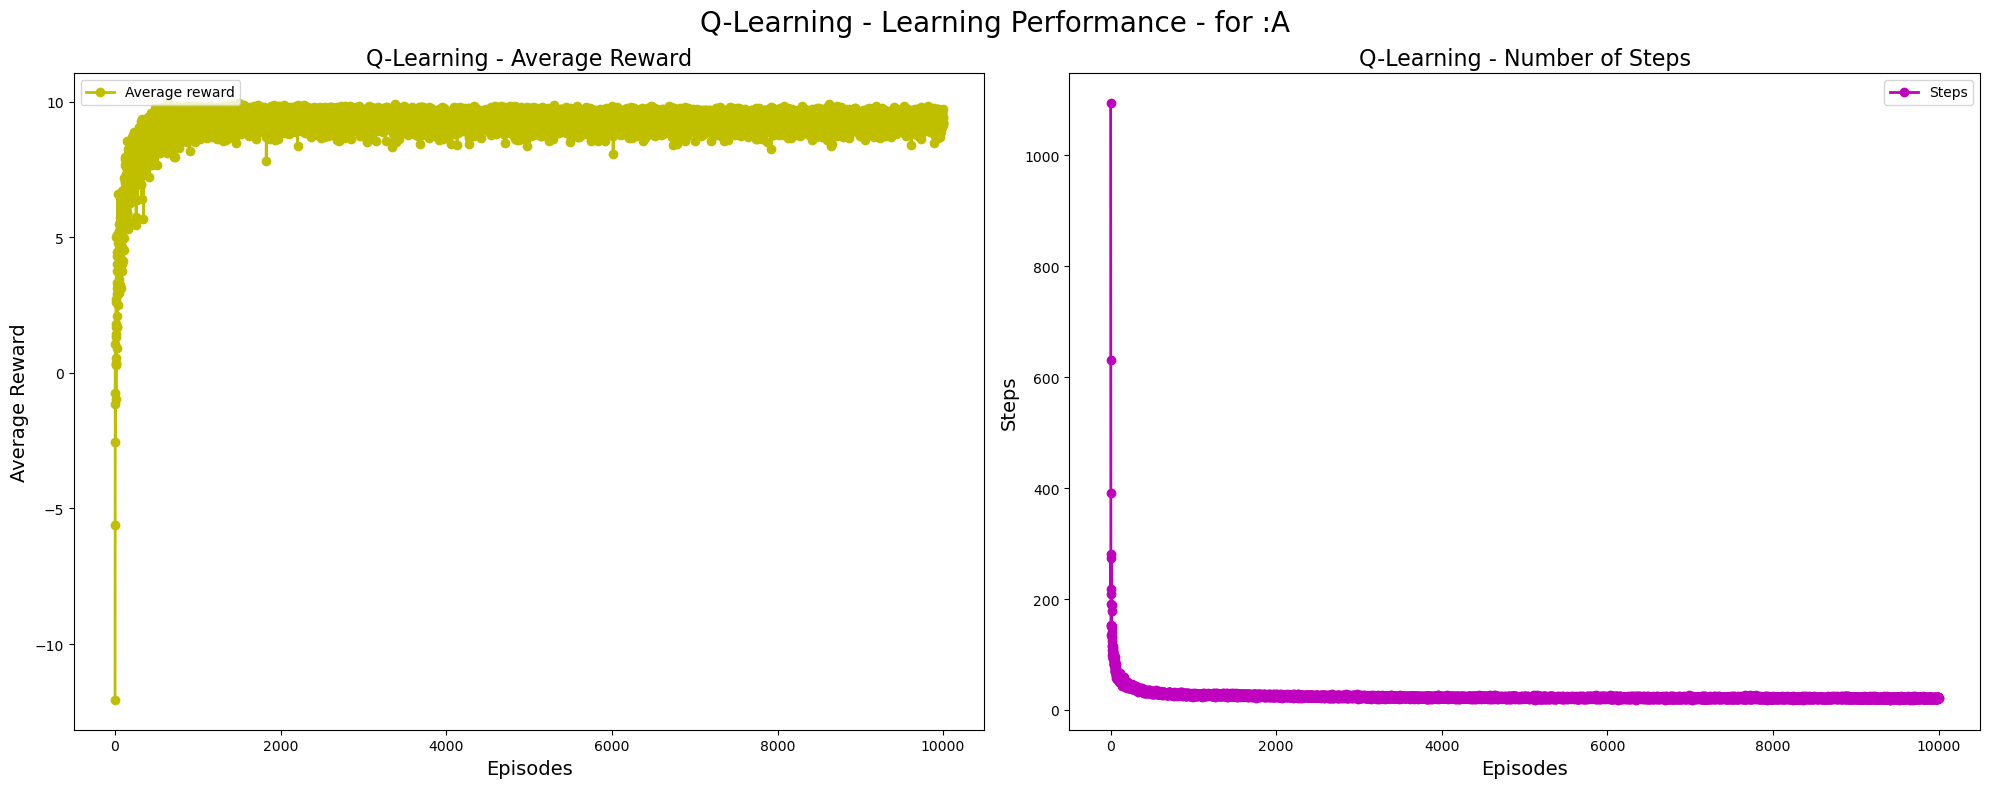

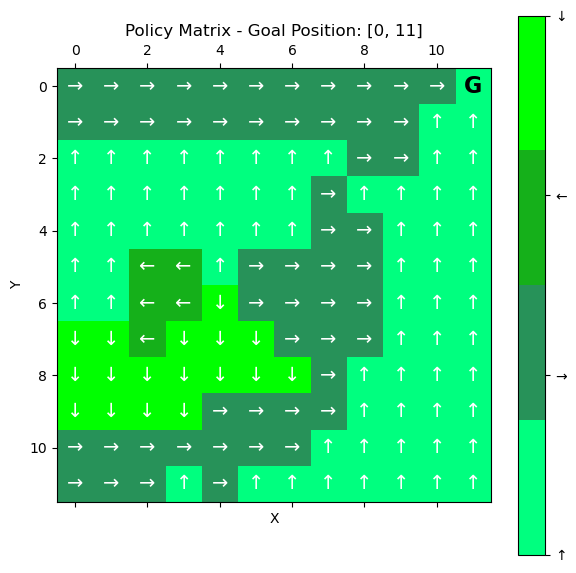

100%|██████████| 10000/10000 [00:18<00:00, 550.41it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0           1            -2              799
1           2           -10              852
2           3            -5               87
3           4             6              107
4           5             5              386
...       ...           ...              ...
9995     9996             8               11
9996     9997            10               12
9997     9998            10               12
9998     9999             9               12
9999    10000            10               25

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 561.59it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1            10              885
1           2            -8               42
2           3             4               77
3           4            10              172
4           5             0               52
...       ...           ...              ...
9995     9996            10               11
9996     9997             9               13
9997     9998            10               13
9998     9999             9               14
9999    10000            10               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 560.23it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1            -7              655
1           2            -5              332
2           3            10               95
3           4             8              556
4           5             7              246
...       ...           ...              ...
9995     9996            10               40
9996     9997            10               13
9997     9998             9               26
9998     9999            10               26
9999    10000             9               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 556.19it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1             5             2390
1           2             4               78
2           3             0               17
3           4            10              175
4           5             1               13
...       ...           ...              ...
9995     9996            10               25
9996     9997            10               32
9997     9998             7               17
9998     9999            10               38
9999    10000             9               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 533.65it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1             8              596
1           2             8              469
2           3            10              721
3           4           -39               36
4           5           -14              492
...       ...           ...              ...
9995     9996             5               35
9996     9997             8               37
9997     9998            10               40
9998     9999             8               11
9999    10000             7               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 529.78it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1             9              296
1           2            -1              479
2           3             0             1976
3           4            10              272
4           5             9              431
...       ...           ...              ...
9995     9996            10               30
9996     9997             8               14
9997     9998            10               12
9998     9999             9               16
9999    10000             9               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:21<00:00, 455.72it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0           1            -7             1299
1           2           -17              158
2           3           -10               16
3           4             7              254
4           5            -4               91
...       ...           ...              ...
9995     9996            10               13
9996     9997            10               28
9997     9998            10               30
9998     9999            10               23
9999    10000             9               25

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 525.68it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0           1             1             2419
1           2             3              198
2           3             5              382
3           4             3              265
4           5             9              417
...       ...           ...              ...
9995     9996            10               23
9996     9997            10               24
9997     9998            10               22
9998     9999            10               27
9999    10000             9               11

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 560.12it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1            10              712
1           2            10              243
2           3             9              856
3           4           -32              102
4           5            -2               79
...       ...           ...              ...
9995     9996             9               20
9996     9997            10                9
9997     9998            10               13
9998     9999            10               19
9999    10000            10               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 544.74it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1            10             1249
1           2             3               96
2           3            -4              712
3           4            -2              260
4           5             9              360
...       ...           ...              ...
9995     9996            10                9
9996     9997            10               37
9997     9998            10               16
9998     9999            10               31
9999    10000             7               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 553.12it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1           -17              773
1           2             8              409
2           3             6              261
3           4            -4             1357
4           5             3              142
...       ...           ...              ...
9995     9996             2               11
9996     9997            10               18
9997     9998            10               19
9998     9999             9               15
9999    10000             7               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 551.71it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1             2             1564
1           2             5              281
2           3           -16               96
3           4            -8              892
4           5             9              319
...       ...           ...              ...
9995     9996            10               12
9996     9997            10               17
9997     9998            10               24
9998     9999             9               38
9999    10000            10               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 571.82it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1           -40             1477
1           2             9             2689
2           3             4              183
3           4            10              164
4           5           -40              182
...       ...           ...              ...
9995     9996            10               38
9996     9997            10               21
9997     9998            10               10
9998     9999            10               26
9999    10000            10               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 559.19it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1             7             2047
1           2           -14              222
2           3             3               47
3           4             8              120
4           5            10              131
...       ...           ...              ...
9995     9996             8               15
9996     9997            10               31
9997     9998            10               10
9998     9999            10               21
9999    10000            10               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 557.96it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0           1           -11              210
1           2            -9               33
2           3           -10              302
3           4             0              139
4           5             4              114
...       ...           ...              ...
9995     9996            10               18
9996     9997             9               13
9997     9998            10               11
9998     9999            10               14
9999    10000            10               26

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 517.38it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1            10              313
1           2             4               99
2           3           -10              122
3           4            -5               24
4           5            10              185
...       ...           ...              ...
9995     9996             9               13
9996     9997            10               25
9997     9998             9               17
9998     9999            10               24
9999    10000            10               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 541.25it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1           -37             2950
1           2           -11             1247
2           3            10              279
3           4            10              113
4           5             2              112
...       ...           ...              ...
9995     9996             9               22
9996     9997             8               11
9997     9998            10               25
9998     9999            10               28
9999    10000             6               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 558.17it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 4.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1            -6              144
1           2             8              128
2           3            10              164
3           4            10               90
4           5            -6              326
...       ...           ...              ...
9995     9996            10                9
9996     9997            10               18
9997     9998            10               27
9998     9999            10               31
9999    10000             4               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 564.51it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 51.0


Episode  Total Reward  Number of Steps
0           1             3              349
1           2            10              486
2           3            10              186
3           4            -2              130
4           5             7               58
...       ...           ...              ...
9995     9996             9               12
9996     9997            10               12
9997     9998            10               29
9998     9999             8               15
9999    10000            10               51

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:20<00:00, 486.84it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1            -3              631
1           2             1              697
2           3             4             1233
3           4             8              142
4           5            -9               25
...       ...           ...              ...
9995     9996            10               12
9996     9997             9               26
9997     9998            10               19
9998     9999             9               27
9999    10000             9               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 544.45it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1            -7             2142
1           2            -2               19
2           3            10               99
3           4             6              775
4           5            10             1348
...       ...           ...              ...
9995     9996            10               29
9996     9997            10               16
9997     9998             9                9
9998     9999            10               32
9999    10000             9               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 561.10it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1             5             2732
1           2           -33             1194
2           3            -7               38
3           4            -4               28
4           5             9              294
...       ...           ...              ...
9995     9996            10               27
9996     9997            10               30
9997     9998             3               11
9998     9999             9               20
9999    10000            10               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 540.03it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0           1           -55             2378
1           2            10              482
2           3             0               23
3           4             9               49
4           5             1               17
...       ...           ...              ...
9995     9996             8               13
9996     9997            10               31
9997     9998             9               14
9998     9999            10               16
9999    10000            10               20

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:21<00:00, 460.68it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1           -12             3911
1           2            -2              382
2           3            -6              309
3           4             7               36
4           5             0              196
...       ...           ...              ...
9995     9996             6               31
9996     9997            10               19
9997     9998            10               19
9998     9999            10               33
9999    10000             9               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 573.04it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 3.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1             0               73
1           2            10              270
2           3             8              239
3           4             5              622
4           5           -19               17
...       ...           ...              ...
9995     9996             8               13
9996     9997             8               16
9997     9998             9               13
9998     9999            10               37
9999    10000             3               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 572.36it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 27.0


Episode  Total Reward  Number of Steps
0           1             3               13
1           2            10             2270
2           3             0               43
3           4           -11              769
4           5             6              101
...       ...           ...              ...
9995     9996             9               30
9996     9997            10               32
9997     9998            10               33
9998     9999            10               11
9999    10000            10               27

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 587.81it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 10.0


Episode  Total Reward  Number of Steps
0           1             4             1860
1           2             7              185
2           3            -5               27
3           4           -11               54
4           5             8              262
...       ...           ...              ...
9995     9996            -2               38
9996     9997            10               35
9997     9998             9               14
9998     9999             6                8
9999    10000            10               10

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 544.79it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode  Total Reward  Number of Steps
0           1             6             2852
1           2           -42              149
2           3           -57             3675
3           4            -1              104
4           5             9              283
...       ...           ...              ...
9995     9996             9               13
9996     9997            10               18
9997     9998            10               44
9998     9999             9               11
9999    10000            10               12

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 534.95it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1             6             1896
1           2           -40              792
2           3           -11              321
3           4            10              129
4           5           -10              222
...       ...           ...              ...
9995     9996             8               15
9996     9997            10               26
9997     9998            10               30
9998     9999            -2               25
9999    10000            10               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 509.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 38.0


Episode  Total Reward  Number of Steps
0           1            -3             3521
1           2            10              601
2           3             8              586
3           4            -8               46
4           5             9              355
...       ...           ...              ...
9995     9996            10               20
9996     9997            10               13
9997     9998            10               11
9998     9999            10               30
9999    10000            10               38

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 524.45it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1           -24              287
1           2             0              720
2           3            -4              575
3           4            10               57
4           5            -1               47
...       ...           ...              ...
9995     9996            10               16
9996     9997            10               32
9997     9998            10               19
9998     9999            10               25
9999    10000            10               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 535.26it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1             1              219
1           2           -10              708
2           3            10              688
3           4             2              304
4           5             9              277
...       ...           ...              ...
9995     9996             9               13
9996     9997            10               25
9997     9998            10               22
9998     9999             6               14
9999    10000            10               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 546.57it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1            -2               77
1           2            10              254
2           3           -28               83
3           4             2              817
4           5           -11               67
...       ...           ...              ...
9995     9996             8               22
9996     9997            10               24
9997     9998             7               20
9998     9999             9               11
9999    10000            10               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 560.18it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1             7             1531
1           2             3              925
2           3            -3              413
3           4           -12              389
4           5           -12               94
...       ...           ...              ...
9995     9996             4               12
9996     9997            10               11
9997     9998            10               48
9998     9999            10               31
9999    10000            10               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:21<00:00, 472.31it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1           -23             1123
1           2            -5              157
2           3             7              269
3           4           -12               46
4           5           -17               95
...       ...           ...              ...
9995     9996            10               27
9996     9997            -2               37
9997     9998             1               19
9998     9999            10               47
9999    10000             9               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:23<00:00, 433.72it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0           1            -1              117
1           2             8              563
2           3            -8               68
3           4            -3              334
4           5            -3              481
...       ...           ...              ...
9995     9996            10               38
9996     9997            10               19
9997     9998            10               20
9998     9999            10               22
9999    10000            10               30

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 558.60it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 34.0


Episode  Total Reward  Number of Steps
0           1             0               53
1           2            10              148
2           3             5              450
3           4             7               78
4           5            -7              171
...       ...           ...              ...
9995     9996             9                8
9996     9997            10               12
9997     9998            10               10
9998     9999             8               42
9999    10000            10               34

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 539.00it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0           1             0             2198
1           2           -13               13
2           3             3             1896
3           4            -8               21
4           5             6              454
...       ...           ...              ...
9995     9996            10               14
9996     9997             8               14
9997     9998             9                8
9998     9999            10               26
9999    10000            10               28

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 568.89it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1             4              172
1           2             0              861
2           3             5               77
3           4             6              142
4           5             9              141
...       ...           ...              ...
9995     9996            10               29
9996     9997            10               10
9997     9998             8               10
9998     9999            10               25
9999    10000             8               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 546.29it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1           -12              462
1           2             6              238
2           3           -10              186
3           4             7              379
4           5            -4              327
...       ...           ...              ...
9995     9996            10               11
9996     9997             9               33
9997     9998            10               38
9998     9999             9               24
9999    10000             9               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 555.00it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 36.0


Episode  Total Reward  Number of Steps
0           1             6              928
1           2           -39              718
2           3             5              291
3           4            -6              242
4           5            10              138
...       ...           ...              ...
9995     9996             9               26
9996     9997             9               26
9997     9998            10               18
9998     9999            10               25
9999    10000            10               36

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 527.81it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1           -34               51
1           2           -14             2289
2           3             3              778
3           4            -2               80
4           5             9               77
...       ...           ...              ...
9995     9996            10               26
9996     9997            10               20
9997     9998            10               17
9998     9999            10               30
9999    10000            10               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 546.02it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1            -7              171
1           2             1               14
2           3            -2               19
3           4             2             1664
4           5             4               31
...       ...           ...              ...
9995     9996             8               30
9996     9997            10               16
9997     9998            10               19
9998     9999             9               11
9999    10000            10               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 520.35it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode  Total Reward  Number of Steps
0           1           -13             1392
1           2           -14              658
2           3           -25             1046
3           4            -5              271
4           5            10              120
...       ...           ...              ...
9995     9996            10               25
9996     9997            10               12
9997     9998             8               13
9998     9999            10               15
9999    10000            10               13

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 520.57it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 31.0


Episode  Total Reward  Number of Steps
0           1             0              835
1           2           -27              904
2           3             9              257
3           4            -2               36
4           5            -5              162
...       ...           ...              ...
9995     9996            10               59
9996     9997             9               17
9997     9998            10               30
9998     9999             7               14
9999    10000            10               31

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 533.66it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 37.0


Episode  Total Reward  Number of Steps
0           1            10              158
1           2            -8               23
2           3            10               85
3           4           -10              134
4           5           -12               42
...       ...           ...              ...
9995     9996            10               35
9996     9997            10               36
9997     9998             7               28
9998     9999            10                9
9999    10000            10               37

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 546.48it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 28.0


Episode  Total Reward  Number of Steps
0           1            -5              447
1           2            -7              256
2           3           -31               57
3           4            10              366
4           5            10              233
...       ...           ...              ...
9995     9996            10               34
9996     9997            10               14
9997     9998            10               19
9998     9999            10               12
9999    10000            10               28

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 535.52it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 1.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0           1           -29              560
1           2             0               71
2           3            -6               54
3           4            10              515
4           5            10              305
...       ...           ...              ...
9995     9996             9               26
9996     9997             8               29
9997     9998            10               36
9998     9999             8               21
9999    10000             1               11

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 520.85it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 45.0


Episode  Total Reward  Number of Steps
0           1           -10              382
1           2             8             2037
2           3           -17              693
3           4           -16              423
4           5            -7              268
...       ...           ...              ...
9995     9996            10               12
9996     9997             9               29
9997     9998            10               15
9998     9999            10               19
9999    10000            10               45

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 534.13it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1             6              563
1           2           -10              402
2           3            -2              102
3           4            -5               18
4           5           -24              248
...       ...           ...              ...
9995     9996            10               25
9996     9997             9               14
9997     9998             6               23
9998     9999             9               11
9999    10000            10               23

[10000 rows x 3 columns]

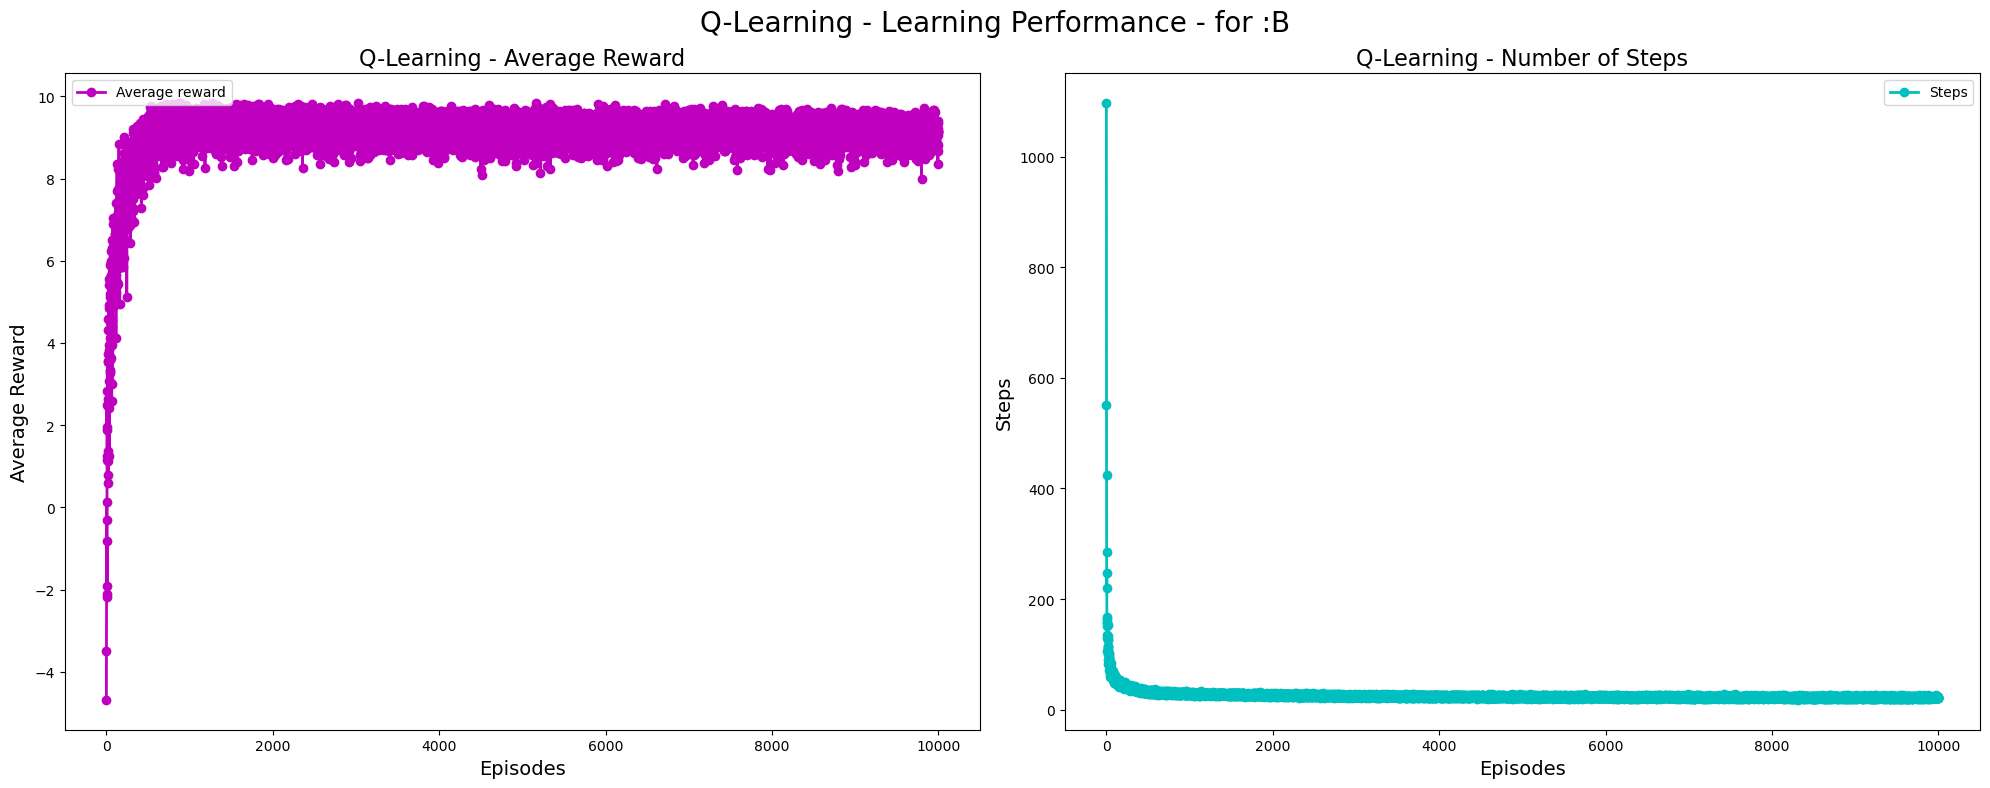

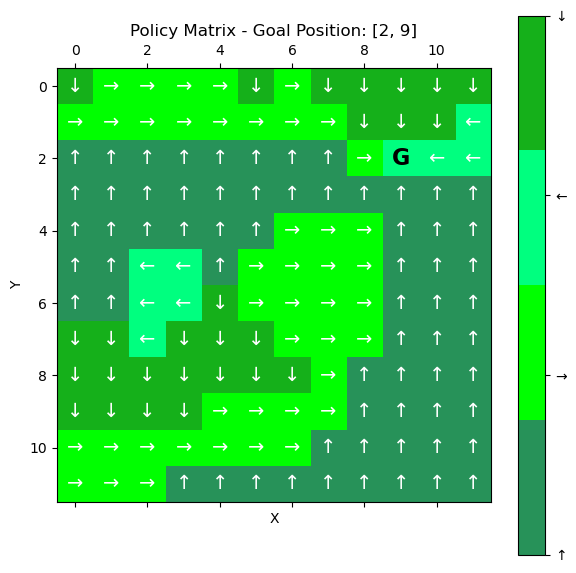

100%|██████████| 10000/10000 [00:12<00:00, 814.53it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 25.0


Episode  Total Reward  Number of Steps
0           1          -176             4803
1           2            -4              518
2           3          -129             5187
3           4             3              371
4           5           -18              896
...       ...           ...              ...
9995     9996             9               14
9996     9997             8               20
9997     9998             9               31
9998     9999             8               23
9999    10000             9               25

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1070.55it/s]

-----------All episodes done-----------
Episode 10000: Total reward = -1.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0           1           -14              990
1           2            -2              478
2           3            -3              187
3           4           -44             1210
4           5             6              335
...       ...           ...              ...
9995     9996             7               17
9996     9997             7               15
9997     9998             8               16
9998     9999             8               14
9999    10000            -1               24

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 990.20it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1          -129             3778
1           2           -15             1174
2           3             4              598
3           4           -18              130
4           5          -191             3445
...       ...           ...              ...
9995     9996             8               20
9996     9997             2               32
9997     9998             8               20
9998     9999             7               25
9999    10000             8               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:13<00:00, 752.42it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1            -3               76
1           2           -19               99
2           3          -160             2242
3           4           -76             1935
4           5             4              175
...       ...           ...              ...
9995     9996             8               15
9996     9997             8               18
9997     9998             4               20
9998     9999             8               21
9999    10000             8               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1007.53it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0           1          -191             3143
1           2             6              210
2           3             3              141
3           4             1             1017
4           5           -16             1101
...       ...           ...              ...
9995     9996             8               15
9996     9997             5               18
9997     9998             8               13
9998     9999             7               24
9999    10000             8               20

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 824.40it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1          -181             1234
1           2          -119             3119
2           3             8              776
3           4            -2              929
4           5             9              111
...       ...           ...              ...
9995     9996             7               17
9996     9997             7               15
9997     9998             8               18
9998     9999             7               16
9999    10000             8               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1001.60it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 13.0


Episode  Total Reward  Number of Steps
0           1           -68             2100
1           2          -119             2967
2           3          -131             5064
3           4           -20              460
4           5           -37             1224
...       ...           ...              ...
9995     9996             2               18
9996     9997             8               14
9997     9998             8               15
9998     9999             5               26
9999    10000             8               13

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1000.60it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1            -4             1122
1           2             6               69
2           3            -1              389
3           4           -10              907
4           5             9              189
...       ...           ...              ...
9995     9996             8               15
9996     9997             8               18
9997     9998             7               37
9998     9999             7               13
9999    10000             9               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 891.64it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1          -281             3232
1           2             0              154
2           3            -7              215
3           4             8              234
4           5             6              141
...       ...           ...              ...
9995     9996             8               12
9996     9997             7               20
9997     9998             7               18
9998     9999             6               20
9999    10000             8               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 885.19it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1           -93             3606
1           2           -22             1000
2           3          -107             3611
3           4           -35             3591
4           5            -1              878
...       ...           ...              ...
9995     9996             8               13
9996     9997             8               23
9997     9998             8               16
9998     9999            -1               21
9999    10000             9               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 788.13it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1          -411            10763
1           2           -39             2288
2           3             0              520
3           4           -18              699
4           5           -47             2045
...       ...           ...              ...
9995     9996            -1               28
9996     9997             8               16
9997     9998             2               20
9998     9999             8               33
9999    10000             8               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 856.53it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 11.0


Episode  Total Reward  Number of Steps
0           1           -31              796
1           2          -101             2589
2           3           -31             1656
3           4             0              106
4           5           -73             4019
...       ...           ...              ...
9995     9996             7               17
9996     9997             4               14
9997     9998             5               27
9998     9999             8               13
9999    10000             8               11

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 821.42it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1          -131             1122
1           2          -122             3708
2           3          -169             8351
3           4          -126             8944
4           5           -19             1100
...       ...           ...              ...
9995     9996             7               18
9996     9997             8               14
9997     9998             8               14
9998     9999             6               19
9999    10000             8               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 896.49it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 29.0


Episode  Total Reward  Number of Steps
0           1             0              533
1           2           -22              432
2           3          -104             2407
3           4            -4               95
4           5             3              179
...       ...           ...              ...
9995     9996             9               27
9996     9997             8               17
9997     9998             8               14
9998     9999             6               23
9999    10000             9               29

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 800.19it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 22.0


Episode  Total Reward  Number of Steps
0           1           -65              937
1           2           -75             1389
2           3             5              602
3           4           -61             1299
4           5             5              285
...       ...           ...              ...
9995     9996             9               22
9996     9997             9               17
9997     9998             8               23
9998     9999             9               18
9999    10000             8               22

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 844.95it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 14.0


Episode  Total Reward  Number of Steps
0           1            -9              462
1           2             7              386
2           3           -27              732
3           4          -210             2655
4           5             1              466
...       ...           ...              ...
9995     9996             7               25
9996     9997             8               13
9997     9998             8               20
9998     9999             8               16
9999    10000             7               14

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 805.78it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 26.0


Episode  Total Reward  Number of Steps
0           1            -4              892
1           2            -7               60
2           3           -50              832
3           4          -130             7374
4           5           -16              265
...       ...           ...              ...
9995     9996             5               23
9996     9997             9               15
9997     9998             7               16
9998     9999             8               19
9999    10000             7               26

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 999.70it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1           -17              642
1           2            -1              108
2           3           -41             2511
3           4             8              147
4           5           -39              787
...       ...           ...              ...
9995     9996             3               18
9996     9997             8               17
9997     9998             8               11
9998     9999             8               19
9999    10000             7               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 887.16it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1          -394             9836
1           2             4              196
2           3           -76             4918
3           4             6              283
4           5             5              360
...       ...           ...              ...
9995     9996             7               16
9996     9997             6               25
9997     9998             8               15
9998     9999             8               11
9999    10000             7               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 860.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 13.0


Episode  Total Reward  Number of Steps
0           1          -266             8991
1           2           -22             2028
2           3           -16             1704
3           4             4              289
4           5             5               41
...       ...           ...              ...
9995     9996             8               22
9996     9997             8               17
9997     9998             7               19
9998     9999             8               18
9999    10000             8               13

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 902.53it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 5.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1          -501            14432
1           2             5              119
2           3           -63             3908
3           4           -31             1514
4           5            -2              840
...       ...           ...              ...
9995     9996             8               17
9996     9997             8               16
9997     9998             7               19
9998     9999             9               19
9999    10000             5               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 861.55it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1          -228             4206
1           2            -7              981
2           3           -52             1517
3           4           -92             3397
4           5            -8              463
...       ...           ...              ...
9995     9996             8               11
9996     9997             8               15
9997     9998             8               14
9998     9999             8               20
9999    10000             6               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 907.60it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1           -30              544
1           2           -33             1323
2           3           -22             2149
3           4           -56             2153
4           5           -79             3454
...       ...           ...              ...
9995     9996             8               12
9996     9997             7               18
9997     9998             8               11
9998     9999             8               18
9999    10000             8               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 936.24it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1           -17               92
1           2           -60             1117
2           3           -32             1591
3           4           -61             2268
4           5           -12              272
...       ...           ...              ...
9995     9996             8               12
9996     9997             8               15
9997     9998             7               22
9998     9999             8               17
9999    10000             8               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 791.85it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 4.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0           1          -172             4391
1           2          -152             5639
2           3           -80             5036
3           4           -28              578
4           5          -122             5688
...       ...           ...              ...
9995     9996             5               26
9996     9997             8               12
9997     9998             7               13
9998     9999             8               17
9999    10000             4               24

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 961.54it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1            -8               32
1           2           -89             1398
2           3            -4              238
3           4          -201             4883
4           5            -8              669
...       ...           ...              ...
9995     9996             8               24
9996     9997             8               20
9997     9998             8               15
9998     9999             8               18
9999    10000             9               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1005.43it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1           -14              139
1           2            -7              363
2           3             9               98
3           4           -58              132
4           5             2               98
...       ...           ...              ...
9995     9996             4               21
9996     9997             7               18
9997     9998             5               22
9998     9999             8               14
9999    10000             7               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1052.85it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1           -40             1812
1           2             7              255
2           3            -4              937
3           4           -88             1391
4           5             9              336
...       ...           ...              ...
9995     9996             5               18
9996     9997             5               24
9997     9998             9               17
9998     9999             8               19
9999    10000             8               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 819.61it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1            -9              170
1           2           -98             1212
2           3           -45             2319
3           4            -8               45
4           5            -5              803
...       ...           ...              ...
9995     9996             2               21
9996     9997             8               12
9997     9998             8               11
9998     9999             7               18
9999    10000             9               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 977.23it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1           -71              302
1           2           -39              940
2           3           -17              535
3           4          -100             4584
4           5             9              279
...       ...           ...              ...
9995     9996             7               16
9996     9997             7               20
9997     9998             8               14
9998     9999             8               14
9999    10000             8               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 818.67it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1          -102             1052
1           2           -65             2607
2           3          -224             4404
3           4           -66             1428
4           5           -41             1597
...       ...           ...              ...
9995     9996             9               16
9996     9997             9               13
9997     9998             9               18
9998     9999             9               22
9999    10000             9               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 874.28it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 13.0


Episode  Total Reward  Number of Steps
0           1           -80              210
1           2          -100              819
2           3           -87             3011
3           4             8              383
4           5            -1              527
...       ...           ...              ...
9995     9996             9               20
9996     9997             8               13
9997     9998             9               20
9998     9999             8               18
9999    10000             8               13

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 877.66it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1          -250             8503
1           2           -11               79
2           3           -40              286
3           4           -77             1028
4           5           -11              668
...       ...           ...              ...
9995     9996             8               30
9996     9997             8               20
9997     9998             8               16
9998     9999             7               20
9999    10000             8               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 928.24it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 20.0


Episode  Total Reward  Number of Steps
0           1           -12              171
1           2          -127             4801
2           3           -45             2689
3           4            -8             1058
4           5           -48             2253
...       ...           ...              ...
9995     9996             8               18
9996     9997             8               18
9997     9998             8               12
9998     9999             8               15
9999    10000             9               20

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 831.67it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1           -13              116
1           2           -30              517
2           3             7               95
3           4           -62              666
4           5            -4              830
...       ...           ...              ...
9995     9996             6               15
9996     9997             6               20
9997     9998             7               29
9998     9999             7               17
9999    10000             8               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 959.14it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 2.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1          -170             4593
1           2           -36             1785
2           3            -3              327
3           4            -3             1348
4           5             8              126
...       ...           ...              ...
9995     9996             8               29
9996     9997             8               15
9997     9998             6               26
9998     9999             8               13
9999    10000             2               23

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 854.12it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 5.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1          -200             3805
1           2             6              154
2           3           -19             1476
3           4           -35             1187
4           5             7             1203
...       ...           ...              ...
9995     9996            -3               29
9996     9997             6               18
9997     9998             8               12
9998     9999             8               23
9999    10000             5               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 897.99it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 15.0


Episode  Total Reward  Number of Steps
0           1          -101             1275
1           2           -27             1498
2           3           -15              446
3           4           -32              218
4           5          -207             6407
...       ...           ...              ...
9995     9996             4               17
9996     9997             8               14
9997     9998             8               11
9998     9999             7               15
9999    10000             7               15

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 815.39it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1          -199             4956
1           2           -89             5731
2           3           -61             3484
3           4             9              240
4           5             5              654
...       ...           ...              ...
9995     9996             8               15
9996     9997             9               22
9997     9998             8               22
9998     9999             8               12
9999    10000             6               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 782.57it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 30.0


Episode  Total Reward  Number of Steps
0           1          -274             7611
1           2             9              139
2           3             7              541
3           4           -15             1200
4           5            -5              447
...       ...           ...              ...
9995     9996             8               26
9996     9997             0               34
9997     9998             9               17
9998     9999             9               16
9999    10000             9               30

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:13<00:00, 734.54it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 4.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1          -118              722
1           2           -98             1718
2           3          -230             4866
3           4          -582            43165
4           5             4              668
...       ...           ...              ...
9995     9996             9               15
9996     9997             8               17
9997     9998             5               18
9998     9999             8               12
9999    10000             4               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 829.88it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1          -215             4058
1           2             5              366
2           3           -38              523
3           4           -35             1616
4           5           -14              381
...       ...           ...              ...
9995     9996             8               12
9996     9997             8               14
9997     9998             8               14
9998     9999             8               17
9999    10000             7               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 850.19it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 16.0


Episode  Total Reward  Number of Steps
0           1          -127             2310
1           2            -9              533
2           3            -4              491
3           4           -39              758
4           5           -41              127
...       ...           ...              ...
9995     9996             8               14
9996     9997             6               15
9997     9998             6               18
9998     9999             8               15
9999    10000             7               16

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 886.52it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 19.0


Episode  Total Reward  Number of Steps
0           1           -42              718
1           2          -135             5984
2           3           -11              229
3           4             6              403
4           5             9              107
...       ...           ...              ...
9995     9996             8               15
9996     9997             8               17
9997     9998             8               20
9998     9999             7               20
9999    10000             7               19

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 771.07it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1           -93              510
1           2          -111             2258
2           3             4              779
3           4             9              339
4           5            -6              398
...       ...           ...              ...
9995     9996             9               14
9996     9997             8               16
9997     9998             7               16
9998     9999             9               24
9999    10000             9               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 880.98it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 24.0


Episode  Total Reward  Number of Steps
0           1           -10              163
1           2           -40              555
2           3           -79             1032
3           4           -64             1403
4           5             8              138
...       ...           ...              ...
9995     9996             5               21
9996     9997             7               14
9997     9998             8               15
9998     9999             6               17
9999    10000             6               24

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:13<00:00, 718.38it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode  Total Reward  Number of Steps
0           1           -67              739
1           2           -36             1171
2           3           -20              610
3           4            -5              518
4           5             2              258
...       ...           ...              ...
9995     9996             9               21
9996     9997             9               16
9997     9998             5               30
9998     9999             9               15
9999    10000             9               21

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 871.37it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 4.0, Number of steps = 17.0


Episode  Total Reward  Number of Steps
0           1          -109             2252
1           2           -37              248
2           3           -13              666
3           4           -23             1106
4           5             9              101
...       ...           ...              ...
9995     9996             6               20
9996     9997             7               15
9997     9998             8               20
9998     9999             6               24
9999    10000             4               17

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 922.42it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 18.0


Episode  Total Reward  Number of Steps
0           1           -31              692
1           2           -77             3613
2           3           -36              683
3           4           -36              852
4           5           -45              566
...       ...           ...              ...
9995     9996             5               28
9996     9997             8               16
9997     9998             8               14
9998     9999             8               22
9999    10000             8               18

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:13<00:00, 758.14it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 23.0


Episode  Total Reward  Number of Steps
0           1          -162             3094
1           2           -45             1059
2           3           -32             1037
3           4          -168             7093
4           5           -33             4838
...       ...           ...              ...
9995     9996             9               22
9996     9997             9               21
9997     9998             9               18
9998     9999             8               20
9999    10000             7               23

[10000 rows x 3 columns]

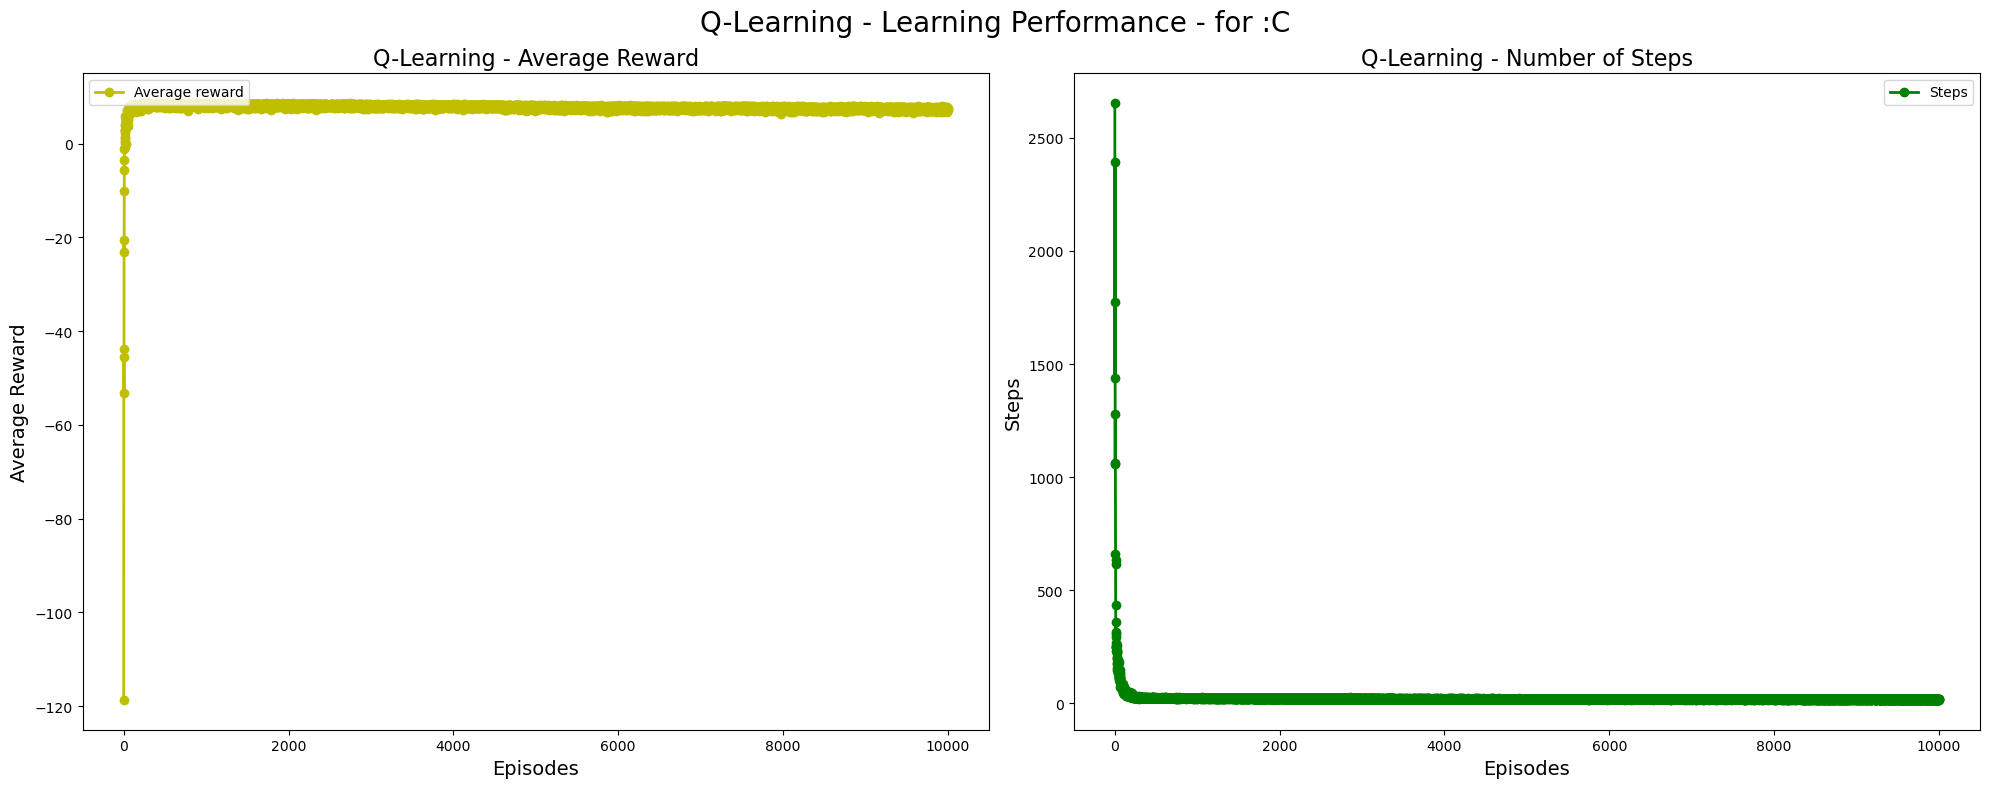

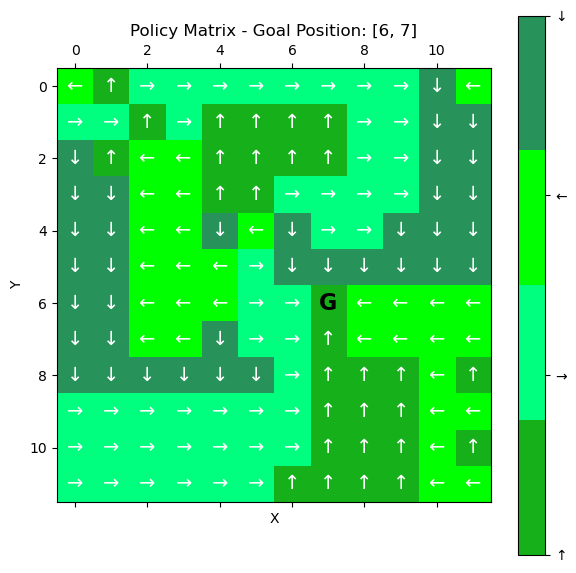

In [10]:
for goal_QLearning in ['A','B','C']:
    # Get the goal position from the goal_positions dictionary
    goal_pos_QLearning = goal_positions.get(goal_QLearning, [0, 11])
    
    # Run 50 independent run
    episode_data_list_QLearning = []
    
    for _ in range(independent_run):
        avg_reward, steps, Q = algo_object_QLearning.episode_run(gamma, alpha, epsilon, episodes, PuddleWorld(), goal_QLearning)
        episode_data_list_QLearning.append((avg_reward, steps, Q))        
    
    # Calculate the average rewards and average steps over the 50 runs
    avg_rewards_QLearning, avg_steps_QLearning = np.zeros([episodes]),np.zeros([episodes])
    
    for i in range(episodes):
        for j in range(len(episode_data_list_QLearning)):
            avg_rewards_QLearning[i] += episode_data_list_QLearning[j][0][i]/len(episode_data_list_QLearning)
            avg_steps_QLearning[i] += episode_data_list_QLearning[j][1][i]/len(episode_data_list_QLearning)
    
    # Calculate the policy matrix based on the most common action in each state
    policy_matrix_QLearning = np.zeros((12, 12), dtype=int)
    action_counts_QLearning = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for i in range(12):
        for j in range(12):
            for k in range(len(episode_data_list_QLearning)):
                action_counts_QLearning[np.argmax(episode_data_list_QLearning[k][2], axis=QLearning_axis)[i, j]] += 1
            max_action_QLearning = max(action_counts_QLearning, key=action_counts_QLearning.get)
            action_counts_QLearning = {0: 0, 1: 0, 2: 0, 3: 0}
            policy_matrix_QLearning[i, j] = max_action_QLearning        
    
    # Plot the reward and steps per episode for the current goal using Q Learning
    plot_reward_steps(avg_rewards_QLearning, avg_steps_QLearning, episodes, 'Q-Learning', goal_QLearning)
    
    # Plot the policy matrix for the current goal using Q Learning
    plot_policy(goal_pos_QLearning, policy_matrix_QLearning)

### SARSA execution for each goal

100%|██████████| 10000/10000 [00:16<00:00, 600.85it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 35.0


Episode                                         Avg Reward  \
0           1  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
1           2  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
2           3  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
3           4  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
4           5  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
...       ...                                                ...   
9995     9996  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
9996     9997  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
9997     9998  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
9998     9999  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   
9999    10000  [8.0, 2.0, -16.0, 5.0, 7.0, -37.0, -14.0, 10.0...   

      Number of Steps  
0               361.0  
1               195.0  
2               171.0  
3                48.0  
4                71.0  
...               ...  
9995             16.0  
9996             33.0  
9997             23.0  
9998             53.0  
9999             35.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 576.70it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
1           2  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
2           3  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
3           4  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
4           5  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
...       ...                                                ...   
9995     9996  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
9996     9997  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
9997     9998  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
9998     9999  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   
9999    10000  [-33.0, -2.0, -1.0, -9.0, -21.0, -4.0, -15.0, ...   

      Number of Steps  
0              3538.0  
1               133.0  
2                33.0  
3                31.0  
4               662.0  
...               ...  
9995             28.0  
9996             19.0  
9997             20.0  
9998             18.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 568.51it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
1           2  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
2           3  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
3           4  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
4           5  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
...       ...                                                ...   
9995     9996  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
9996     9997  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
9997     9998  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
9998     9999  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   
9999    10000  [3.0, 2.0, -6.0, -8.0, -1.0, 8.0, -2.0, 6.0, 0...   

      Number of Steps  
0               202.0  
1               102.0  
2               534.0  
3               114.0  
4                29.0  
...               ...  
9995             16.0  
9996             24.0  
9997             29.0  
9998             32.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 583.99it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 5.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
1           2  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
2           3  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
3           4  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
4           5  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
...       ...                                                ...   
9995     9996  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
9996     9997  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
9997     9998  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
9998     9999  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   
9999    10000  [10.0, -2.0, -26.0, 5.0, 10.0, 1.0, -6.0, 10.0...   

      Number of Steps  
0               892.0  
1                37.0  
2                43.0  
3               723.0  
4               460.0  
...               ...  
9995             40.0  
9996             10.0  
9997             27.0  
9998             14.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 584.25it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
1           2  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
2           3  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
3           4  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
4           5  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
...       ...                                                ...   
9995     9996  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
9996     9997  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
9997     9998  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
9998     9999  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   
9999    10000  [-11.0, -1.0, -52.0, -9.0, 9.0, -36.0, -11.0, ...   

      Number of Steps  
0               160.0  
1                71.0  
2               149.0  
3                62.0  
4               118.0  
...               ...  
9995             15.0  
9996             25.0  
9997             14.0  
9998             21.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 602.05it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
1           2  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
2           3  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
3           4  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
4           5  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
...       ...                                                ...   
9995     9996  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
9996     9997  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
9997     9998  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
9998     9999  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   
9999    10000  [8.0, 4.0, 4.0, 10.0, -4.0, 8.0, 1.0, -11.0, 5...   

      Number of Steps  
0               737.0  
1               229.0  
2                95.0  
3               170.0  
4               136.0  
...               ...  
9995             25.0  
9996             15.0  
9997             23.0  
9998             32.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 588.87it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0           1  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
1           2  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
2           3  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
3           4  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
4           5  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
...       ...                                                ...   
9995     9996  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
9996     9997  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
9997     9998  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
9998     9999  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   
9999    10000  [-31.0, 7.0, 1.0, -37.0, 0.0, -24.0, 10.0, 10....   

      Number of Steps  
0               448.0  
1               140.0  
2               110.0  
3                69.0  
4               151.0  
...               ...  
9995             27.0  
9996             18.0  
9997             22.0  
9998             33.0  
9999             31.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 581.39it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0           1  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
1           2  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
2           3  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
3           4  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
4           5  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
...       ...                                                ...   
9995     9996  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
9996     9997  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
9997     9998  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
9998     9999  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   
9999    10000  [-2.0, -7.0, -10.0, 10.0, -7.0, 9.0, 10.0, -1....   

      Number of Steps  
0               774.0  
1                60.0  
2               365.0  
3               219.0  
4               712.0  
...               ...  
9995             31.0  
9996             36.0  
9997             36.0  
9998             10.0  
9999             25.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 588.13it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
1           2  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
2           3  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
3           4  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
4           5  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
...       ...                                                ...   
9995     9996  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
9996     9997  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
9997     9998  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
9998     9999  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   
9999    10000  [7.0, -14.0, -2.0, -12.0, 4.0, -6.0, -22.0, 0....   

      Number of Steps  
0                31.0  
1              2653.0  
2               474.0  
3                96.0  
4               649.0  
...               ...  
9995             22.0  
9996             20.0  
9997             13.0  
9998             11.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 598.07it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
1           2  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
2           3  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
3           4  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
4           5  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
...       ...                                                ...   
9995     9996  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
9996     9997  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
9997     9998  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
9998     9999  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   
9999    10000  [-18.0, -3.0, 7.0, -3.0, -15.0, 4.0, -8.0, -14...   

      Number of Steps  
0               753.0  
1               130.0  
2               143.0  
3                36.0  
4                30.0  
...               ...  
9995             19.0  
9996             19.0  
9997             21.0  
9998             14.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 614.99it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0           1  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
1           2  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
2           3  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
3           4  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
4           5  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
...       ...                                                ...   
9995     9996  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
9996     9997  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
9997     9998  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
9998     9999  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   
9999    10000  [-5.0, 4.0, -29.0, 8.0, 4.0, 4.0, 9.0, -3.0, 0...   

      Number of Steps  
0               223.0  
1                49.0  
2                43.0  
3               143.0  
4                66.0  
...               ...  
9995             34.0  
9996             20.0  
9997             26.0  
9998             27.0  
9999             31.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:15<00:00, 628.90it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 38.0


Episode                                         Avg Reward  \
0           1  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
1           2  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
2           3  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
3           4  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
4           5  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
...       ...                                                ...   
9995     9996  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
9996     9997  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
9997     9998  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
9998     9999  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   
9999    10000  [0.0, -10.0, -3.0, 6.0, -13.0, -6.0, 6.0, 0.0,...   

      Number of Steps  
0              1031.0  
1                39.0  
2                91.0  
3               292.0  
4                55.0  
...               ...  
9995             15.0  
9996             21.0  
9997             27.0  
9998             17.0  
9999             38.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 597.27it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 30.0


Episode                                         Avg Reward  \
0           1  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
1           2  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
2           3  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
3           4  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
4           5  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
...       ...                                                ...   
9995     9996  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
9996     9997  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
9997     9998  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
9998     9999  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   
9999    10000  [-30.0, 7.0, 7.0, 9.0, 10.0, 10.0, 10.0, 10.0,...   

      Number of Steps  
0               622.0  
1                88.0  
2               692.0  
3                74.0  
4               384.0  
...               ...  
9995             17.0  
9996             11.0  
9997             15.0  
9998             16.0  
9999             30.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 577.20it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0           1  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
1           2  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
2           3  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
3           4  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
4           5  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
...       ...                                                ...   
9995     9996  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
9996     9997  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
9997     9998  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
9998     9999  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   
9999    10000  [3.0, 1.0, -5.0, 6.0, 10.0, -2.0, -3.0, 0.0, 8...   

      Number of Steps  
0              1536.0  
1               540.0  
2               220.0  
3               258.0  
4               117.0  
...               ...  
9995             13.0  
9996             32.0  
9997             12.0  
9998             21.0  
9999             27.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 614.38it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
1           2  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
2           3  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
3           4  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
4           5  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
...       ...                                                ...   
9995     9996  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
9996     9997  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
9997     9998  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
9998     9999  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   
9999    10000  [-4.0, 8.0, -18.0, 10.0, 10.0, 10.0, 9.0, -13....   

      Number of Steps  
0               918.0  
1               233.0  
2               437.0  
3               178.0  
4               272.0  
...               ...  
9995             20.0  
9996             18.0  
9997             19.0  
9998             19.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 567.83it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 45.0


Episode                                         Avg Reward  \
0           1  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
1           2  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
2           3  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
3           4  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
4           5  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
...       ...                                                ...   
9995     9996  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
9996     9997  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
9997     9998  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
9998     9999  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   
9999    10000  [-25.0, 1.0, 1.0, 10.0, 10.0, 8.0, 10.0, 7.0, ...   

      Number of Steps  
0               180.0  
1               278.0  
2               246.0  
3               272.0  
4               128.0  
...               ...  
9995             32.0  
9996             17.0  
9997             19.0  
9998             17.0  
9999             45.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 592.91it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
1           2  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
2           3  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
3           4  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
4           5  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
...       ...                                                ...   
9995     9996  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
9996     9997  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
9997     9998  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
9998     9999  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   
9999    10000  [-10.0, -20.0, 10.0, -5.0, 4.0, 7.0, 2.0, 9.0,...   

      Number of Steps  
0                96.0  
1               961.0  
2               157.0  
3               115.0  
4               103.0  
...               ...  
9995             24.0  
9996             29.0  
9997             26.0  
9998             11.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 607.53it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0           1  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
1           2  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
2           3  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
3           4  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
4           5  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
...       ...                                                ...   
9995     9996  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
9996     9997  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
9997     9998  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
9998     9999  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   
9999    10000  [-11.0, 6.0, 7.0, 3.0, -6.0, 3.0, 9.0, 4.0, 7....   

      Number of Steps  
0              1745.0  
1               145.0  
2               133.0  
3                37.0  
4                27.0  
...               ...  
9995             17.0  
9996             25.0  
9997             25.0  
9998             23.0  
9999             22.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 591.19it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 9.0


Episode                                         Avg Reward  \
0           1  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
1           2  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
2           3  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
3           4  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
4           5  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
...       ...                                                ...   
9995     9996  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
9996     9997  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
9997     9998  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
9998     9999  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   
9999    10000  [-6.0, -16.0, 2.0, -3.0, 5.0, -8.0, 5.0, -32.0...   

      Number of Steps  
0                33.0  
1              1739.0  
2               688.0  
3               332.0  
4               234.0  
...               ...  
9995             12.0  
9996             13.0  
9997             25.0  
9998             22.0  
9999              9.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 572.79it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0           1  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
1           2  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
2           3  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
3           4  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
4           5  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
...       ...                                                ...   
9995     9996  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
9996     9997  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
9997     9998  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
9998     9999  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   
9999    10000  [-23.0, 6.0, -5.0, -1.0, 10.0, 6.0, 1.0, 2.0, ...   

      Number of Steps  
0              2700.0  
1               813.0  
2               320.0  
3              1039.0  
4               358.0  
...               ...  
9995             23.0  
9996             12.0  
9997             35.0  
9998             15.0  
9999             34.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 603.61it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
1           2  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
2           3  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
3           4  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
4           5  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
...       ...                                                ...   
9995     9996  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
9996     9997  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
9997     9998  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
9998     9999  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   
9999    10000  [-28.0, 1.0, 10.0, 5.0, -12.0, 3.0, 10.0, 2.0,...   

      Number of Steps  
0                46.0  
1                31.0  
2               451.0  
3              2041.0  
4              1083.0  
...               ...  
9995             16.0  
9996             28.0  
9997             20.0  
9998             20.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 583.39it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
1           2  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
2           3  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
3           4  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
4           5  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
...       ...                                                ...   
9995     9996  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
9996     9997  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
9997     9998  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
9998     9999  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   
9999    10000  [-4.0, 5.0, -16.0, 10.0, -5.0, 9.0, 9.0, -5.0,...   

      Number of Steps  
0               799.0  
1               111.0  
2               105.0  
3                90.0  
4                48.0  
...               ...  
9995             13.0  
9996             18.0  
9997             13.0  
9998             13.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 539.52it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
1           2  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
2           3  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
3           4  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
4           5  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
...       ...                                                ...   
9995     9996  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
9996     9997  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
9997     9998  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
9998     9999  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   
9999    10000  [-37.0, 9.0, -14.0, -16.0, 3.0, -3.0, 8.0, -4....   

      Number of Steps  
0              5535.0  
1               784.0  
2               312.0  
3                43.0  
4               272.0  
...               ...  
9995             13.0  
9996             14.0  
9997             17.0  
9998             18.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 604.74it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0           1  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
1           2  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
2           3  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
3           4  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
4           5  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
...       ...                                                ...   
9995     9996  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
9996     9997  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
9997     9998  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
9998     9999  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   
9999    10000  [9.0, 3.0, 10.0, 7.0, 10.0, 10.0, 10.0, -5.0, ...   

      Number of Steps  
0               314.0  
1                66.0  
2               174.0  
3               218.0  
4                95.0  
...               ...  
9995             28.0  
9996             16.0  
9997             26.0  
9998             31.0  
9999             25.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 595.90it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
1           2  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
2           3  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
3           4  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
4           5  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
...       ...                                                ...   
9995     9996  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
9996     9997  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
9997     9998  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
9998     9999  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   
9999    10000  [2.0, 10.0, 10.0, -28.0, -19.0, -28.0, 0.0, 10...   

      Number of Steps  
0               383.0  
1               654.0  
2               158.0  
3               147.0  
4               155.0  
...               ...  
9995             28.0  
9996             22.0  
9997             25.0  
9998             19.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 608.98it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0           1  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
1           2  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
2           3  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
3           4  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
4           5  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
...       ...                                                ...   
9995     9996  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
9996     9997  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
9997     9998  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
9998     9999  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   
9999    10000  [-47.0, 3.0, 5.0, -1.0, -13.0, -13.0, 1.0, -12...   

      Number of Steps  
0               865.0  
1                45.0  
2                58.0  
3                61.0  
4                51.0  
...               ...  
9995             17.0  
9996             16.0  
9997             21.0  
9998             20.0  
9999             26.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 529.77it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
1           2  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
2           3  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
3           4  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
4           5  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
...       ...                                                ...   
9995     9996  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
9996     9997  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
9997     9998  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
9998     9999  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   
9999    10000  [-7.0, -28.0, 10.0, 5.0, 3.0, 10.0, -17.0, -6....   

      Number of Steps  
0               665.0  
1               843.0  
2               699.0  
3               423.0  
4               319.0  
...               ...  
9995             12.0  
9996             12.0  
9997             39.0  
9998             33.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 581.19it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 37.0


Episode                                         Avg Reward  \
0           1  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
1           2  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
2           3  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
3           4  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
4           5  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
...       ...                                                ...   
9995     9996  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
9996     9997  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
9997     9998  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
9998     9999  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   
9999    10000  [9.0, 8.0, 3.0, 9.0, 9.0, 3.0, -4.0, 9.0, 9.0,...   

      Number of Steps  
0               963.0  
1               738.0  
2                45.0  
3               433.0  
4               167.0  
...               ...  
9995             31.0  
9996             31.0  
9997             18.0  
9998             12.0  
9999             37.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 591.21it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 37.0


Episode                                         Avg Reward  \
0           1  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
1           2  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
2           3  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
3           4  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
4           5  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
...       ...                                                ...   
9995     9996  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
9996     9997  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
9997     9998  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
9998     9999  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   
9999    10000  [-24.0, 1.0, 1.0, 10.0, 4.0, -10.0, 4.0, -4.0,...   

      Number of Steps  
0              3127.0  
1                31.0  
2                45.0  
3               234.0  
4               277.0  
...               ...  
9995             13.0  
9996             25.0  
9997             30.0  
9998             11.0  
9999             37.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 581.67it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
1           2  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
2           3  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
3           4  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
4           5  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
...       ...                                                ...   
9995     9996  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
9996     9997  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
9997     9998  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
9998     9999  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   
9999    10000  [-10.0, -10.0, 2.0, 5.0, 6.0, -3.0, 10.0, 0.0,...   

      Number of Steps  
0               305.0  
1               110.0  
2               552.0  
3                84.0  
4               299.0  
...               ...  
9995             24.0  
9996             11.0  
9997             11.0  
9998             25.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 593.37it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0           1  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
1           2  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
2           3  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
3           4  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
4           5  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
...       ...                                                ...   
9995     9996  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
9996     9997  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
9997     9998  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
9998     9999  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   
9999    10000  [-3.0, -4.0, 10.0, -4.0, -3.0, -12.0, 6.0, 1.0...   

      Number of Steps  
0                68.0  
1              1494.0  
2                78.0  
3                48.0  
4               220.0  
...               ...  
9995             42.0  
9996             13.0  
9997             21.0  
9998             41.0  
9999             25.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 592.01it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0           1  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
1           2  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
2           3  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
3           4  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
4           5  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
...       ...                                                ...   
9995     9996  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
9996     9997  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
9997     9998  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
9998     9999  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   
9999    10000  [-15.0, 1.0, 10.0, -14.0, 8.0, -4.0, 10.0, 10....   

      Number of Steps  
0               165.0  
1                60.0  
2                49.0  
3               114.0  
4               152.0  
...               ...  
9995             14.0  
9996             12.0  
9997             42.0  
9998             23.0  
9999             23.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 592.52it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
1           2  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
2           3  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
3           4  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
4           5  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
...       ...                                                ...   
9995     9996  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
9996     9997  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
9997     9998  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
9998     9999  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   
9999    10000  [1.0, -18.0, -29.0, 10.0, 10.0, 0.0, 9.0, 10.0...   

      Number of Steps  
0               575.0  
1                31.0  
2              1783.0  
3               236.0  
4               144.0  
...               ...  
9995             30.0  
9996             31.0  
9997             29.0  
9998             18.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 592.70it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0           1  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
1           2  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
2           3  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
3           4  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
4           5  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
...       ...                                                ...   
9995     9996  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
9996     9997  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
9997     9998  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
9998     9999  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   
9999    10000  [9.0, 10.0, 10.0, -17.0, 5.0, 10.0, -3.0, -10....   

      Number of Steps  
0               797.0  
1                72.0  
2               128.0  
3               183.0  
4               172.0  
...               ...  
9995             29.0  
9996             29.0  
9997             28.0  
9998             27.0  
9999             18.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 607.38it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 28.0


Episode                                         Avg Reward  \
0           1  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
1           2  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
2           3  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
3           4  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
4           5  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
...       ...                                                ...   
9995     9996  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
9996     9997  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
9997     9998  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
9998     9999  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   
9999    10000  [9.0, -6.0, -1.0, 3.0, 5.0, 10.0, -9.0, -2.0, ...   

      Number of Steps  
0               101.0  
1               102.0  
2                62.0  
3                72.0  
4                33.0  
...               ...  
9995             20.0  
9996             25.0  
9997             26.0  
9998             12.0  
9999             28.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 575.21it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
1           2  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
2           3  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
3           4  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
4           5  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
...       ...                                                ...   
9995     9996  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
9996     9997  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
9997     9998  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
9998     9999  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   
9999    10000  [-24.0, 4.0, -8.0, -4.0, 2.0, -13.0, 3.0, 2.0,...   

      Number of Steps  
0              1549.0  
1                98.0  
2               470.0  
3                64.0  
4               170.0  
...               ...  
9995             28.0  
9996             15.0  
9997             30.0  
9998             15.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 569.02it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0           1  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
1           2  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
2           3  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
3           4  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
4           5  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
...       ...                                                ...   
9995     9996  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
9996     9997  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
9997     9998  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
9998     9999  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   
9999    10000  [-30.0, 0.0, 10.0, -2.0, 9.0, 10.0, 4.0, -35.0...   

      Number of Steps  
0              1484.0  
1                49.0  
2                70.0  
3               230.0  
4                98.0  
...               ...  
9995             28.0  
9996             16.0  
9997             15.0  
9998             24.0  
9999             18.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 564.13it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0           1  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
1           2  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
2           3  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
3           4  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
4           5  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
...       ...                                                ...   
9995     9996  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
9996     9997  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
9997     9998  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
9998     9999  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   
9999    10000  [-15.0, -18.0, 1.0, 6.0, 2.0, 5.0, -2.0, -4.0,...   

      Number of Steps  
0              1810.0  
1               757.0  
2               520.0  
3               779.0  
4               289.0  
...               ...  
9995             12.0  
9996             15.0  
9997             37.0  
9998             27.0  
9999             23.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 614.39it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
1           2  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
2           3  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
3           4  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
4           5  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
...       ...                                                ...   
9995     9996  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
9996     9997  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
9997     9998  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
9998     9999  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   
9999    10000  [-14.0, 7.0, -15.0, 2.0, -8.0, -31.0, 7.0, 4.0...   

      Number of Steps  
0                20.0  
1               123.0  
2                47.0  
3               252.0  
4               138.0  
...               ...  
9995             14.0  
9996             40.0  
9997             32.0  
9998             29.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 613.79it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 10.0


Episode                                         Avg Reward  \
0           1  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
1           2  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
2           3  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
3           4  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
4           5  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
...       ...                                                ...   
9995     9996  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
9996     9997  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
9997     9998  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
9998     9999  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   
9999    10000  [1.0, 6.0, -18.0, -4.0, 6.0, 3.0, -36.0, -9.0,...   

      Number of Steps  
0               256.0  
1               512.0  
2               637.0  
3               476.0  
4                81.0  
...               ...  
9995             14.0  
9996             26.0  
9997             11.0  
9998             19.0  
9999             10.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 584.65it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
1           2  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
2           3  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
3           4  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
4           5  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
...       ...                                                ...   
9995     9996  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
9996     9997  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
9997     9998  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
9998     9999  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   
9999    10000  [-2.0, 6.0, 8.0, -7.0, 10.0, 1.0, 5.0, -8.0, 8...   

      Number of Steps  
0              2504.0  
1              1169.0  
2               348.0  
3              2424.0  
4               145.0  
...               ...  
9995             15.0  
9996             32.0  
9997             28.0  
9998             14.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 577.25it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
1           2  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
2           3  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
3           4  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
4           5  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
...       ...                                                ...   
9995     9996  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
9996     9997  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
9997     9998  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
9998     9999  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   
9999    10000  [10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.0, 7.0, 7...   

      Number of Steps  
0               245.0  
1               213.0  
2               438.0  
3               228.0  
4               223.0  
...               ...  
9995             31.0  
9996             18.0  
9997             32.0  
9998             17.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 615.67it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0           1  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
1           2  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
2           3  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
3           4  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
4           5  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
...       ...                                                ...   
9995     9996  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
9996     9997  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
9997     9998  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
9998     9999  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   
9999    10000  [10.0, 9.0, -7.0, 6.0, 10.0, 9.0, -4.0, -11.0,...   

      Number of Steps  
0               626.0  
1               483.0  
2               552.0  
3                92.0  
4               340.0  
...               ...  
9995             34.0  
9996             17.0  
9997             19.0  
9998             16.0  
9999             31.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 580.69it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 30.0


Episode                                         Avg Reward  \
0           1  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
1           2  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
2           3  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
3           4  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
4           5  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
...       ...                                                ...   
9995     9996  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
9996     9997  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
9997     9998  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
9998     9999  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   
9999    10000  [2.0, -2.0, 5.0, 1.0, -15.0, 2.0, -6.0, -7.0, ...   

      Number of Steps  
0               213.0  
1               788.0  
2               128.0  
3               108.0  
4               227.0  
...               ...  
9995             16.0  
9996             45.0  
9997             31.0  
9998             18.0  
9999             30.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 589.30it/s]


-----------All episodes done-----------
Episode 10000: Total reward = -3.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
1           2  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
2           3  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
3           4  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
4           5  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
...       ...                                                ...   
9995     9996  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
9996     9997  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
9997     9998  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
9998     9999  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   
9999    10000  [9.0, -19.0, 10.0, 9.0, 9.0, 10.0, 1.0, 10.0, ...   

      Number of Steps  
0               929.0  
1               267.0  
2               266.0  
3               200.0  
4                92.0  
...               ...  
9995             33.0  
9996             12.0  
9997             29.0  
9998             18.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 586.11it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 9.0


Episode                                         Avg Reward  \
0           1  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
1           2  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
2           3  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
3           4  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
4           5  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
...       ...                                                ...   
9995     9996  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
9996     9997  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
9997     9998  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
9998     9999  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   
9999    10000  [-23.0, 6.0, 6.0, -4.0, -22.0, 10.0, -4.0, 7.0...   

      Number of Steps  
0               209.0  
1                88.0  
2               228.0  
3               130.0  
4                57.0  
...               ...  
9995             13.0  
9996             14.0  
9997             25.0  
9998             13.0  
9999              9.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 606.64it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
1           2  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
2           3  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
3           4  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
4           5  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
...       ...                                                ...   
9995     9996  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
9996     9997  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
9997     9998  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
9998     9999  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   
9999    10000  [-1.0, -4.0, -4.0, -8.0, -12.0, -8.0, 10.0, -1...   

      Number of Steps  
0               840.0  
1               203.0  
2               149.0  
3              1233.0  
4               347.0  
...               ...  
9995             39.0  
9996             15.0  
9997             26.0  
9998             16.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 602.81it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
1           2  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
2           3  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
3           4  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
4           5  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
...       ...                                                ...   
9995     9996  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
9996     9997  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
9997     9998  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
9998     9999  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   
9999    10000  [3.0, -14.0, 10.0, 10.0, -3.0, -10.0, 10.0, -1...   

      Number of Steps  
0               461.0  
1                65.0  
2               139.0  
3               226.0  
4                42.0  
...               ...  
9995             16.0  
9996             26.0  
9997             37.0  
9998             12.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 587.44it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 36.0


Episode                                         Avg Reward  \
0           1  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
1           2  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
2           3  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
3           4  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
4           5  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
...       ...                                                ...   
9995     9996  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
9996     9997  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
9997     9998  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
9998     9999  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   
9999    10000  [0.0, -1.0, -21.0, 0.0, -2.0, -27.0, 5.0, 10.0...   

      Number of Steps  
0               589.0  
1               350.0  
2                75.0  
3               154.0  
4                67.0  
...               ...  
9995             30.0  
9996             13.0  
9997             10.0  
9998             23.0  
9999             36.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 574.91it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
1           2  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
2           3  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
3           4  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
4           5  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
...       ...                                                ...   
9995     9996  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
9996     9997  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
9997     9998  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
9998     9999  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   
9999    10000  [-4.0, 7.0, 10.0, -28.0, -10.0, 7.0, 10.0, -2....   

      Number of Steps  
0                36.0  
1                48.0  
2               496.0  
3                38.0  
4               330.0  
...               ...  
9995             27.0  
9996             19.0  
9997             13.0  
9998             13.0  
9999             15.0  

[10000 rows x 3 columns]

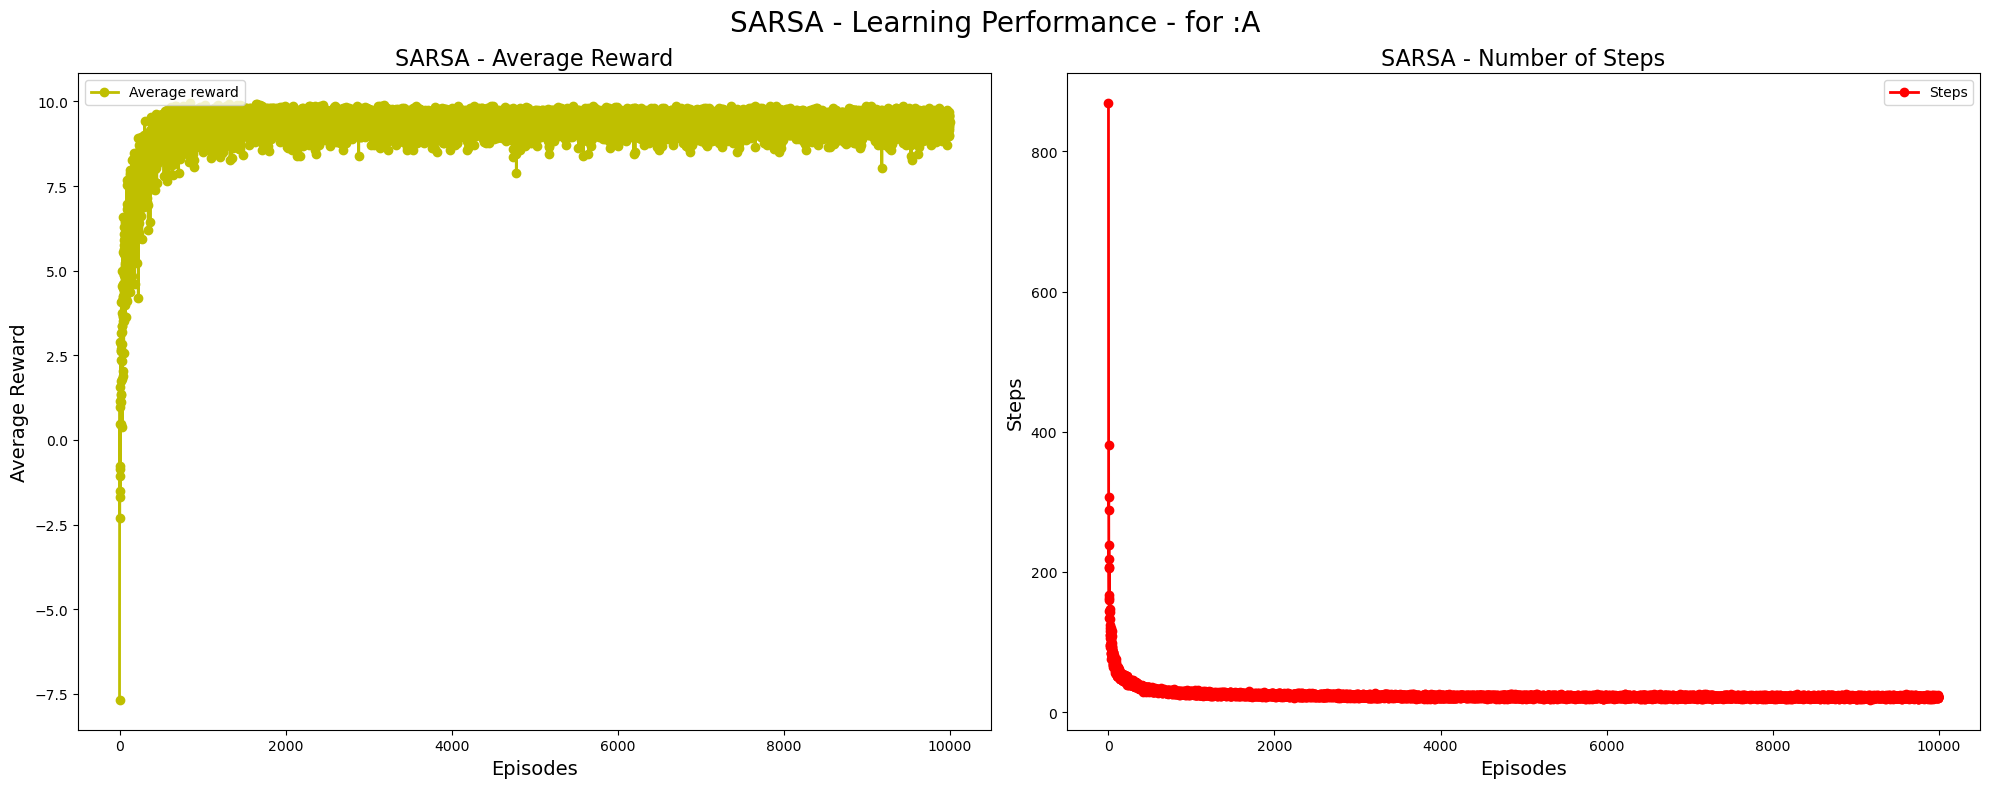

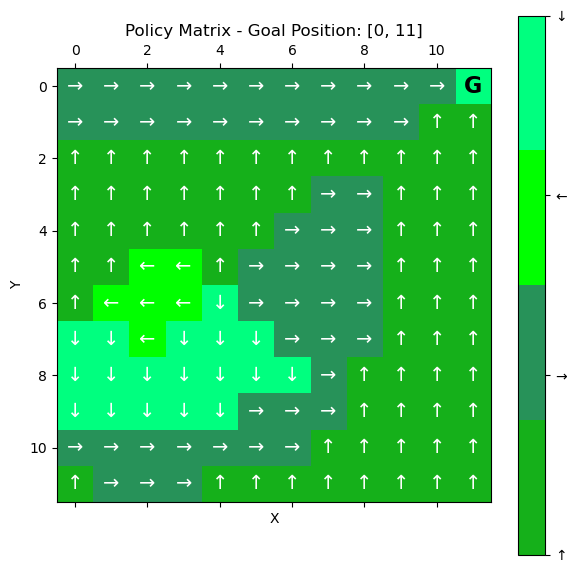

100%|██████████| 10000/10000 [00:18<00:00, 542.83it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
1           2  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
2           3  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
3           4  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
4           5  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
...       ...                                                ...   
9995     9996  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
9996     9997  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
9997     9998  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
9998     9999  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   
9999    10000  [-26.0, -21.0, -20.0, -10.0, 9.0, -3.0, -2.0, ...   

      Number of Steps  
0               716.0  
1                34.0  
2              1007.0  
3               190.0  
4               978.0  
...               ...  
9995             23.0  
9996             11.0  
9997             28.0  
9998             46.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 580.04it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
1           2  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
2           3  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
3           4  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
4           5  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
...       ...                                                ...   
9995     9996  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
9996     9997  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
9997     9998  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
9998     9999  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   
9999    10000  [-3.0, 4.0, 6.0, 10.0, 6.0, 10.0, 2.0, 2.0, -1...   

      Number of Steps  
0                17.0  
1                21.0  
2               650.0  
3               430.0  
4                33.0  
...               ...  
9995             12.0  
9996             27.0  
9997             28.0  
9998             20.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 512.71it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0           1  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
1           2  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
2           3  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
3           4  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
4           5  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
...       ...                                                ...   
9995     9996  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
9996     9997  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
9997     9998  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
9998     9999  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   
9999    10000  [-96.0, -10.0, 5.0, 2.0, 1.0, -1.0, 5.0, 5.0, ...   

      Number of Steps  
0              8285.0  
1               119.0  
2               540.0  
3               168.0  
4                74.0  
...               ...  
9995             18.0  
9996             12.0  
9997             29.0  
9998             31.0  
9999             27.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 562.84it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 8.0


Episode                                         Avg Reward  \
0           1  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
1           2  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
2           3  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
3           4  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
4           5  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
...       ...                                                ...   
9995     9996  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
9996     9997  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
9997     9998  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
9998     9999  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   
9999    10000  [-19.0, -8.0, 0.0, -12.0, -7.0, -8.0, 10.0, 10...   

      Number of Steps  
0               467.0  
1                49.0  
2                87.0  
3                78.0  
4               138.0  
...               ...  
9995             26.0  
9996             16.0  
9997             27.0  
9998             20.0  
9999              8.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 587.91it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
1           2  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
2           3  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
3           4  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
4           5  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
...       ...                                                ...   
9995     9996  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
9996     9997  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
9997     9998  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
9998     9999  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   
9999    10000  [-15.0, -6.0, 5.0, -3.0, 3.0, 7.0, -2.0, 3.0, ...   

      Number of Steps  
0              1002.0  
1               138.0  
2                60.0  
3                84.0  
4               315.0  
...               ...  
9995             17.0  
9996             25.0  
9997             14.0  
9998             25.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 590.95it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 10.0


Episode                                         Avg Reward  \
0           1  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
1           2  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
2           3  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
3           4  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
4           5  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
...       ...                                                ...   
9995     9996  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
9996     9997  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
9997     9998  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
9998     9999  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   
9999    10000  [10.0, 10.0, 0.0, -14.0, -6.0, 0.0, -10.0, 10....   

      Number of Steps  
0               743.0  
1               161.0  
2               151.0  
3                64.0  
4                35.0  
...               ...  
9995             17.0  
9996             10.0  
9997             15.0  
9998             32.0  
9999             10.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 614.03it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
1           2  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
2           3  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
3           4  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
4           5  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
...       ...                                                ...   
9995     9996  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
9996     9997  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
9997     9998  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
9998     9999  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   
9999    10000  [-31.0, -10.0, 3.0, 4.0, -2.0, 7.0, 4.0, 9.0, ...   

      Number of Steps  
0              4636.0  
1              1469.0  
2               886.0  
3               528.0  
4                87.0  
...               ...  
9995             17.0  
9996             23.0  
9997             14.0  
9998             28.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 560.09it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0           1  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
1           2  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
2           3  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
3           4  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
4           5  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
...       ...                                                ...   
9995     9996  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
9996     9997  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
9997     9998  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
9998     9999  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   
9999    10000  [-16.0, -9.0, -3.0, -16.0, -14.0, 10.0, 8.0, 6...   

      Number of Steps  
0              6308.0  
1              1822.0  
2               166.0  
3               440.0  
4               216.0  
...               ...  
9995              9.0  
9996             19.0  
9997             33.0  
9998             26.0  
9999             31.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 526.88it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0           1  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
1           2  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
2           3  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
3           4  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
4           5  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
...       ...                                                ...   
9995     9996  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
9996     9997  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
9997     9998  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
9998     9999  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   
9999    10000  [9.0, -16.0, -2.0, 7.0, 7.0, -4.0, 9.0, 7.0, -...   

      Number of Steps  
0               387.0  
1               636.0  
2              1408.0  
3              1252.0  
4               832.0  
...               ...  
9995              9.0  
9996             32.0  
9997             27.0  
9998             11.0  
9999             25.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 595.06it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
1           2  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
2           3  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
3           4  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
4           5  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
...       ...                                                ...   
9995     9996  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
9996     9997  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
9997     9998  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
9998     9999  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   
9999    10000  [-19.0, -53.0, -3.0, -27.0, -5.0, -5.0, 9.0, 0...   

      Number of Steps  
0              2255.0  
1              2745.0  
2               306.0  
3                79.0  
4               156.0  
...               ...  
9995             23.0  
9996             30.0  
9997             19.0  
9998             17.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 560.43it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0           1  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
1           2  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
2           3  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
3           4  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
4           5  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
...       ...                                                ...   
9995     9996  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
9996     9997  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
9997     9998  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
9998     9999  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   
9999    10000  [-16.0, 7.0, -4.0, 10.0, 8.0, -12.0, 8.0, 10.0...   

      Number of Steps  
0              1101.0  
1               683.0  
2                22.0  
3               163.0  
4                52.0  
...               ...  
9995             16.0  
9996             13.0  
9997             19.0  
9998             19.0  
9999             32.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 560.28it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0           1  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
1           2  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
2           3  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
3           4  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
4           5  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
...       ...                                                ...   
9995     9996  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
9996     9997  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
9997     9998  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
9998     9999  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   
9999    10000  [-30.0, -4.0, -24.0, -52.0, -15.0, 9.0, -1.0, ...   

      Number of Steps  
0               623.0  
1              1182.0  
2               371.0  
3                63.0  
4               786.0  
...               ...  
9995             18.0  
9996             27.0  
9997             52.0  
9998             26.0  
9999             26.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:19<00:00, 521.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
1           2  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
2           3  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
3           4  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
4           5  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
...       ...                                                ...   
9995     9996  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
9996     9997  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
9997     9998  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
9998     9999  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   
9999    10000  [-10.0, 10.0, 4.0, 4.0, 8.0, 4.0, -7.0, 3.0, 9...   

      Number of Steps  
0                85.0  
1               941.0  
2               394.0  
3                80.0  
4               161.0  
...               ...  
9995             15.0  
9996             29.0  
9997             24.0  
9998             18.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 567.81it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 29.0


Episode                                         Avg Reward  \
0           1  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
1           2  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
2           3  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
3           4  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
4           5  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
...       ...                                                ...   
9995     9996  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
9996     9997  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
9997     9998  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
9998     9999  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   
9999    10000  [2.0, -1.0, -1.0, -5.0, 5.0, -1.0, 4.0, 4.0, -...   

      Number of Steps  
0               274.0  
1                71.0  
2                89.0  
3                63.0  
4                82.0  
...               ...  
9995             36.0  
9996             18.0  
9997             16.0  
9998             18.0  
9999             29.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 597.73it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0           1  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
1           2  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
2           3  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
3           4  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
4           5  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
...       ...                                                ...   
9995     9996  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
9996     9997  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
9997     9998  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
9998     9999  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   
9999    10000  [6.0, 5.0, -62.0, 10.0, 8.0, 9.0, 6.0, 10.0, 6...   

      Number of Steps  
0                69.0  
1               716.0  
2              4037.0  
3                92.0  
4               208.0  
...               ...  
9995             12.0  
9996             15.0  
9997             16.0  
9998             43.0  
9999             11.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 571.50it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0           1  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
1           2  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
2           3  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
3           4  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
4           5  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
...       ...                                                ...   
9995     9996  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
9996     9997  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
9997     9998  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
9998     9999  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   
9999    10000  [-61.0, 10.0, 10.0, -4.0, 9.0, 6.0, -7.0, -7.0...   

      Number of Steps  
0              2555.0  
1               196.0  
2               257.0  
3               636.0  
4              1104.0  
...               ...  
9995             20.0  
9996             20.0  
9997             20.0  
9998             20.0  
9999             24.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 555.72it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
1           2  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
2           3  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
3           4  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
4           5  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
...       ...                                                ...   
9995     9996  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
9996     9997  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
9997     9998  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
9998     9999  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   
9999    10000  [-43.0, 5.0, -8.0, -37.0, -7.0, -7.0, 9.0, 1.0...   

      Number of Steps  
0              4428.0  
1               137.0  
2               204.0  
3               486.0  
4               207.0  
...               ...  
9995             27.0  
9996             20.0  
9997             12.0  
9998             31.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 566.93it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0           1  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
1           2  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
2           3  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
3           4  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
4           5  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
...       ...                                                ...   
9995     9996  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
9996     9997  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
9997     9998  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
9998     9999  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   
9999    10000  [-27.0, -10.0, 5.0, 3.0, 10.0, 9.0, -3.0, 10.0...   

      Number of Steps  
0              6119.0  
1               437.0  
2               363.0  
3               159.0  
4                38.0  
...               ...  
9995              9.0  
9996             11.0  
9997             29.0  
9998             12.0  
9999             34.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 542.95it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0           1  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
1           2  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
2           3  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
3           4  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
4           5  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
...       ...                                                ...   
9995     9996  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
9996     9997  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
9997     9998  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
9998     9999  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   
9999    10000  [0.0, 5.0, -15.0, -3.0, 0.0, 2.0, 3.0, -1.0, 9...   

      Number of Steps  
0               224.0  
1               151.0  
2               360.0  
3                41.0  
4                40.0  
...               ...  
9995             37.0  
9996             34.0  
9997             25.0  
9998             32.0  
9999             27.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 561.43it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 32.0


Episode                                         Avg Reward  \
0           1  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
1           2  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
2           3  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
3           4  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
4           5  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
...       ...                                                ...   
9995     9996  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
9996     9997  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
9997     9998  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
9998     9999  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   
9999    10000  [-8.0, 3.0, -5.0, 9.0, -9.0, 10.0, 4.0, -23.0,...   

      Number of Steps  
0              1234.0  
1                37.0  
2               175.0  
3                89.0  
4               145.0  
...               ...  
9995             35.0  
9996             16.0  
9997             14.0  
9998             31.0  
9999             32.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 572.71it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
1           2  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
2           3  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
3           4  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
4           5  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
...       ...                                                ...   
9995     9996  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
9996     9997  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
9997     9998  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
9998     9999  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   
9999    10000  [9.0, 7.0, -16.0, 10.0, -47.0, 5.0, -53.0, -20...   

      Number of Steps  
0               548.0  
1               711.0  
2               297.0  
3                97.0  
4               244.0  
...               ...  
9995             12.0  
9996             23.0  
9997             15.0  
9998             38.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 571.23it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
1           2  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
2           3  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
3           4  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
4           5  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
...       ...                                                ...   
9995     9996  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
9996     9997  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
9997     9998  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
9998     9999  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   
9999    10000  [-65.0, 3.0, -9.0, -18.0, 8.0, 8.0, -26.0, 6.0...   

      Number of Steps  
0              3773.0  
1                22.0  
2               236.0  
3               318.0  
4               457.0  
...               ...  
9995             11.0  
9996             30.0  
9997             38.0  
9998             19.0  
9999             15.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 577.99it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 8.0


Episode                                         Avg Reward  \
0           1  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
1           2  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
2           3  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
3           4  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
4           5  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
...       ...                                                ...   
9995     9996  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
9996     9997  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
9997     9998  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
9998     9999  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   
9999    10000  [-68.0, 10.0, -8.0, -2.0, -12.0, 10.0, 8.0, 8....   

      Number of Steps  
0                72.0  
1               617.0  
2               170.0  
3                23.0  
4               416.0  
...               ...  
9995             11.0  
9996             12.0  
9997             29.0  
9998             23.0  
9999              8.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 586.53it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
1           2  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
2           3  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
3           4  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
4           5  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
...       ...                                                ...   
9995     9996  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
9996     9997  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
9997     9998  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
9998     9999  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   
9999    10000  [3.0, 10.0, 3.0, 10.0, -28.0, -1.0, 9.0, -11.0...   

      Number of Steps  
0               845.0  
1               819.0  
2                41.0  
3               119.0  
4               154.0  
...               ...  
9995             13.0  
9996             14.0  
9997             20.0  
9998             33.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 586.45it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
1           2  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
2           3  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
3           4  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
4           5  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
...       ...                                                ...   
9995     9996  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
9996     9997  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
9997     9998  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
9998     9999  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   
9999    10000  [1.0, 6.0, -6.0, -24.0, 6.0, -15.0, 8.0, -4.0,...   

      Number of Steps  
0              1438.0  
1                48.0  
2              3016.0  
3               672.0  
4               198.0  
...               ...  
9995             54.0  
9996             34.0  
9997             15.0  
9998              9.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 582.86it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
1           2  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
2           3  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
3           4  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
4           5  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
...       ...                                                ...   
9995     9996  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
9996     9997  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
9997     9998  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
9998     9999  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   
9999    10000  [-9.0, -12.0, 6.0, 2.0, 4.0, 9.0, -36.0, 10.0,...   

      Number of Steps  
0              2370.0  
1               225.0  
2                25.0  
3              1661.0  
4               235.0  
...               ...  
9995             29.0  
9996             22.0  
9997             12.0  
9998             15.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 581.43it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0           1  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
1           2  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
2           3  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
3           4  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
4           5  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
...       ...                                                ...   
9995     9996  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
9996     9997  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
9997     9998  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
9998     9999  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   
9999    10000  [-37.0, 2.0, 8.0, -42.0, 0.0, 9.0, 10.0, 10.0,...   

      Number of Steps  
0              1049.0  
1               444.0  
2               385.0  
3              3239.0  
4                80.0  
...               ...  
9995             17.0  
9996             19.0  
9997             18.0  
9998             37.0  
9999             11.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 550.28it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 40.0


Episode                                         Avg Reward  \
0           1  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
1           2  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
2           3  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
3           4  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
4           5  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
...       ...                                                ...   
9995     9996  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
9996     9997  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
9997     9998  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
9998     9999  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   
9999    10000  [9.0, 9.0, 8.0, 8.0, -10.0, -14.0, 10.0, 10.0,...   

      Number of Steps  
0               363.0  
1               416.0  
2               803.0  
3               189.0  
4                91.0  
...               ...  
9995             45.0  
9996             20.0  
9997             13.0  
9998             42.0  
9999             40.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 588.00it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
1           2  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
2           3  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
3           4  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
4           5  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
...       ...                                                ...   
9995     9996  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
9996     9997  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
9997     9998  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
9998     9999  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   
9999    10000  [-65.0, 5.0, 5.0, 7.0, 10.0, 10.0, 9.0, 10.0, ...   

      Number of Steps  
0               848.0  
1               198.0  
2               106.0  
3                97.0  
4               294.0  
...               ...  
9995             10.0  
9996             10.0  
9997             29.0  
9998             17.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 584.02it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 60.0


Episode                                         Avg Reward  \
0           1  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
1           2  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
2           3  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
3           4  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
4           5  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
...       ...                                                ...   
9995     9996  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
9996     9997  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
9997     9998  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
9998     9999  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   
9999    10000  [7.0, -18.0, 8.0, 10.0, 10.0, -9.0, -11.0, 5.0...   

      Number of Steps  
0               145.0  
1               391.0  
2               353.0  
3               399.0  
4               627.0  
...               ...  
9995             22.0  
9996             26.0  
9997             14.0  
9998             12.0  
9999             60.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 592.49it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
1           2  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
2           3  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
3           4  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
4           5  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
...       ...                                                ...   
9995     9996  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
9996     9997  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
9997     9998  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
9998     9999  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   
9999    10000  [-17.0, 2.0, -27.0, 6.0, -12.0, -2.0, 8.0, 1.0...   

      Number of Steps  
0              1792.0  
1                10.0  
2               139.0  
3               153.0  
4               327.0  
...               ...  
9995             13.0  
9996             13.0  
9997             33.0  
9998             23.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 591.09it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
1           2  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
2           3  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
3           4  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
4           5  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
...       ...                                                ...   
9995     9996  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
9996     9997  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
9997     9998  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
9998     9999  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   
9999    10000  [-10.0, -2.0, 2.0, 9.0, 10.0, 9.0, 10.0, 10.0,...   

      Number of Steps  
0               144.0  
1               123.0  
2               376.0  
3               590.0  
4               172.0  
...               ...  
9995             32.0  
9996             24.0  
9997             11.0  
9998             29.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 595.61it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
1           2  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
2           3  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
3           4  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
4           5  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
...       ...                                                ...   
9995     9996  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
9996     9997  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
9997     9998  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
9998     9999  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   
9999    10000  [-40.0, -34.0, 3.0, -12.0, 10.0, 9.0, -4.0, 9....   

      Number of Steps  
0              2048.0  
1               439.0  
2               243.0  
3               268.0  
4               132.0  
...               ...  
9995             26.0  
9996             21.0  
9997             15.0  
9998             34.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 559.64it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0           1  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
1           2  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
2           3  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
3           4  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
4           5  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
...       ...                                                ...   
9995     9996  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
9996     9997  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
9997     9998  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
9998     9999  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   
9999    10000  [-3.0, 10.0, -2.0, 10.0, -7.0, 10.0, 10.0, -13...   

      Number of Steps  
0                24.0  
1               126.0  
2                69.0  
3               207.0  
4               129.0  
...               ...  
9995             12.0  
9996              9.0  
9997             10.0  
9998             25.0  
9999             11.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 581.88it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
1           2  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
2           3  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
3           4  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
4           5  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
...       ...                                                ...   
9995     9996  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
9996     9997  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
9997     9998  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
9998     9999  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   
9999    10000  [8.0, 4.0, 9.0, 1.0, 10.0, 9.0, -21.0, 6.0, -3...   

      Number of Steps  
0               682.0  
1               595.0  
2               596.0  
3                73.0  
4               283.0  
...               ...  
9995             16.0  
9996             11.0  
9997             26.0  
9998             11.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 590.15it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
1           2  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
2           3  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
3           4  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
4           5  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
...       ...                                                ...   
9995     9996  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
9996     9997  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
9997     9998  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
9998     9999  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   
9999    10000  [-59.0, 1.0, 8.0, -9.0, -3.0, -6.0, -36.0, 10....   

      Number of Steps  
0              2050.0  
1               809.0  
2                50.0  
3               111.0  
4               350.0  
...               ...  
9995             12.0  
9996             14.0  
9997             16.0  
9998             24.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 577.76it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 43.0


Episode                                         Avg Reward  \
0           1  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
1           2  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
2           3  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
3           4  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
4           5  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
...       ...                                                ...   
9995     9996  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
9996     9997  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
9997     9998  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
9998     9999  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   
9999    10000  [-24.0, 10.0, 0.0, 10.0, 3.0, -23.0, -23.0, 2....   

      Number of Steps  
0              2133.0  
1                93.0  
2              2099.0  
3               438.0  
4               213.0  
...               ...  
9995             19.0  
9996             12.0  
9997             12.0  
9998             15.0  
9999             43.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 563.31it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
1           2  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
2           3  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
3           4  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
4           5  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
...       ...                                                ...   
9995     9996  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
9996     9997  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
9997     9998  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
9998     9999  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   
9999    10000  [1.0, 3.0, 6.0, 0.0, 7.0, -5.0, 7.0, -5.0, -12...   

      Number of Steps  
0               417.0  
1               132.0  
2               286.0  
3               282.0  
4               310.0  
...               ...  
9995             28.0  
9996             32.0  
9997             21.0  
9998             38.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 600.74it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0           1  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
1           2  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
2           3  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
3           4  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
4           5  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
...       ...                                                ...   
9995     9996  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
9996     9997  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
9997     9998  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
9998     9999  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   
9999    10000  [-11.0, -6.0, 8.0, -15.0, -13.0, 2.0, -1.0, 0....   

      Number of Steps  
0                22.0  
1               263.0  
2               857.0  
3               778.0  
4                17.0  
...               ...  
9995             15.0  
9996             25.0  
9997             16.0  
9998             24.0  
9999             24.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 595.78it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
1           2  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
2           3  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
3           4  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
4           5  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
...       ...                                                ...   
9995     9996  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
9996     9997  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
9997     9998  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
9998     9999  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   
9999    10000  [-29.0, 2.0, -50.0, -8.0, 7.0, 6.0, 9.0, 0.0, ...   

      Number of Steps  
0              4722.0  
1               325.0  
2              1531.0  
3               212.0  
4                60.0  
...               ...  
9995             11.0  
9996             29.0  
9997             15.0  
9998             10.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 540.30it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
1           2  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
2           3  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
3           4  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
4           5  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
...       ...                                                ...   
9995     9996  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
9996     9997  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
9997     9998  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
9998     9999  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   
9999    10000  [-19.0, -1.0, 8.0, 3.0, 9.0, 4.0, -23.0, 4.0, ...   

      Number of Steps  
0              5674.0  
1              1372.0  
2               160.0  
3               381.0  
4                49.0  
...               ...  
9995             20.0  
9996             36.0  
9997             32.0  
9998             13.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 571.35it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
1           2  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
2           3  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
3           4  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
4           5  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
...       ...                                                ...   
9995     9996  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
9996     9997  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
9997     9998  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
9998     9999  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   
9999    10000  [0.0, -1.0, 9.0, 8.0, 2.0, -10.0, 9.0, 9.0, 6....   

      Number of Steps  
0              3221.0  
1                96.0  
2               280.0  
3                82.0  
4               532.0  
...               ...  
9995             40.0  
9996             11.0  
9997             25.0  
9998             34.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 580.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 25.0


Episode                                         Avg Reward  \
0           1  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
1           2  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
2           3  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
3           4  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
4           5  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
...       ...                                                ...   
9995     9996  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
9996     9997  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
9997     9998  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
9998     9999  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   
9999    10000  [2.0, 10.0, 4.0, -12.0, 1.0, 8.0, 0.0, -14.0, ...   

      Number of Steps  
0              1159.0  
1               205.0  
2               164.0  
3               148.0  
4               162.0  
...               ...  
9995             14.0  
9996             19.0  
9997             42.0  
9998             11.0  
9999             25.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 575.44it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0           1  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
1           2  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
2           3  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
3           4  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
4           5  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
...       ...                                                ...   
9995     9996  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
9996     9997  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
9997     9998  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
9998     9999  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   
9999    10000  [6.0, 9.0, 10.0, -30.0, -14.0, -25.0, -3.0, 8....   

      Number of Steps  
0               455.0  
1               528.0  
2               432.0  
3                48.0  
4                53.0  
...               ...  
9995             15.0  
9996             28.0  
9997             22.0  
9998             16.0  
9999             26.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 594.63it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
1           2  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
2           3  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
3           4  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
4           5  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
...       ...                                                ...   
9995     9996  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
9996     9997  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
9997     9998  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
9998     9999  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   
9999    10000  [-31.0, 10.0, -1.0, -8.0, 8.0, -2.0, 2.0, 2.0,...   

      Number of Steps  
0               472.0  
1               348.0  
2               200.0  
3                35.0  
4               516.0  
...               ...  
9995             13.0  
9996             20.0  
9997             23.0  
9998             20.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 569.24it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0           1  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
1           2  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
2           3  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
3           4  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
4           5  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
...       ...                                                ...   
9995     9996  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
9996     9997  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
9997     9998  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
9998     9999  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   
9999    10000  [-19.0, -1.0, 10.0, -8.0, 10.0, -9.0, -9.0, 10...   

      Number of Steps  
0              1306.0  
1                21.0  
2               119.0  
3               173.0  
4               272.0  
...               ...  
9995             21.0  
9996             29.0  
9997             25.0  
9998             40.0  
9999             26.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 578.80it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 37.0


Episode                                         Avg Reward  \
0           1  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
1           2  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
2           3  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
3           4  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
4           5  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
...       ...                                                ...   
9995     9996  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
9996     9997  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
9997     9998  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
9998     9999  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   
9999    10000  [8.0, 1.0, 10.0, 10.0, 2.0, -9.0, -1.0, -8.0, ...   

      Number of Steps  
0              1232.0  
1               126.0  
2               377.0  
3               254.0  
4               103.0  
...               ...  
9995             11.0  
9996             17.0  
9997             35.0  
9998             25.0  
9999             37.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:16<00:00, 599.15it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
1           2  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
2           3  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
3           4  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
4           5  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
...       ...                                                ...   
9995     9996  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
9996     9997  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
9997     9998  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
9998     9999  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   
9999    10000  [-7.0, -2.0, 10.0, 4.0, -4.0, 5.0, 8.0, 2.0, 0...   

      Number of Steps  
0               743.0  
1                66.0  
2               705.0  
3               364.0  
4               359.0  
...               ...  
9995             13.0  
9996             22.0  
9997             14.0  
9998             11.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:17<00:00, 575.43it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 10.0, Number of steps = 10.0


Episode                                         Avg Reward  \
0           1  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
1           2  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
2           3  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
3           4  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
4           5  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
...       ...                                                ...   
9995     9996  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
9996     9997  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
9997     9998  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
9998     9999  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   
9999    10000  [10.0, -5.0, -1.0, 10.0, -16.0, 10.0, -3.0, 10...   

      Number of Steps  
0               657.0  
1                40.0  
2                60.0  
3               123.0  
4                33.0  
...               ...  
9995             27.0  
9996             23.0  
9997             20.0  
9998             25.0  
9999             10.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:18<00:00, 551.15it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0           1  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
1           2  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
2           3  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
3           4  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
4           5  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
...       ...                                                ...   
9995     9996  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
9996     9997  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
9997     9998  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
9998     9999  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   
9999    10000  [-15.0, -1.0, 3.0, 0.0, -2.0, -11.0, 1.0, 10.0...   

      Number of Steps  
0              1186.0  
1               133.0  
2                87.0  
3               508.0  
4                98.0  
...               ...  
9995             23.0  
9996             28.0  
9997             38.0  
9998             11.0  
9999             11.0  

[10000 rows x 3 columns]

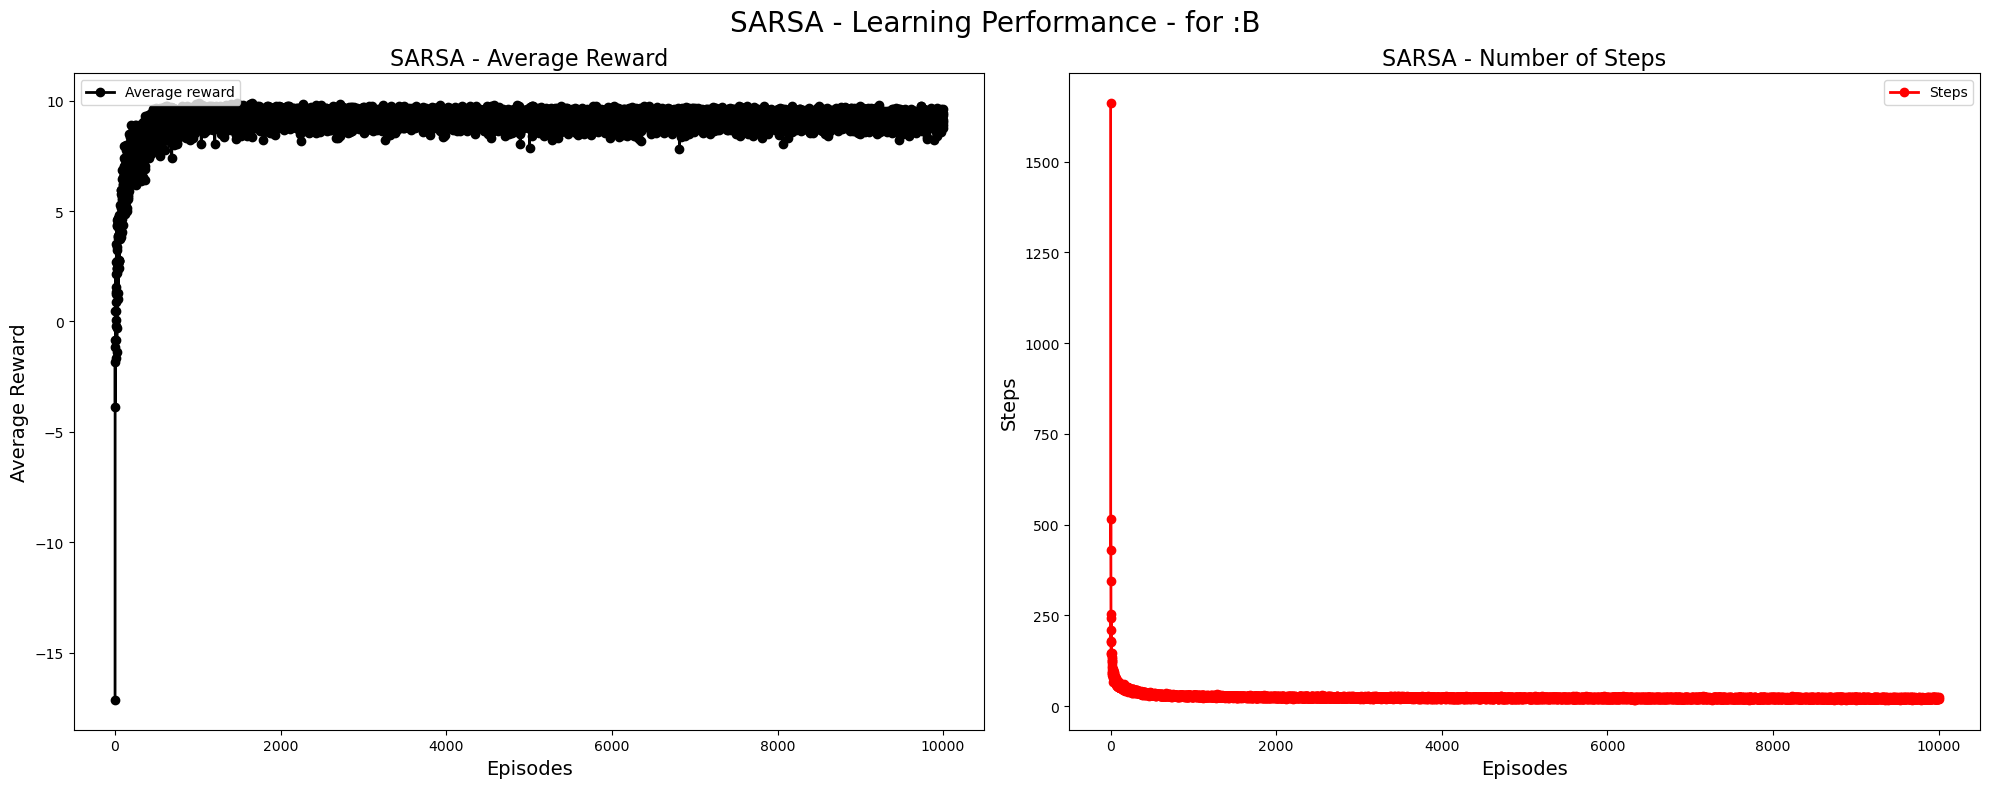

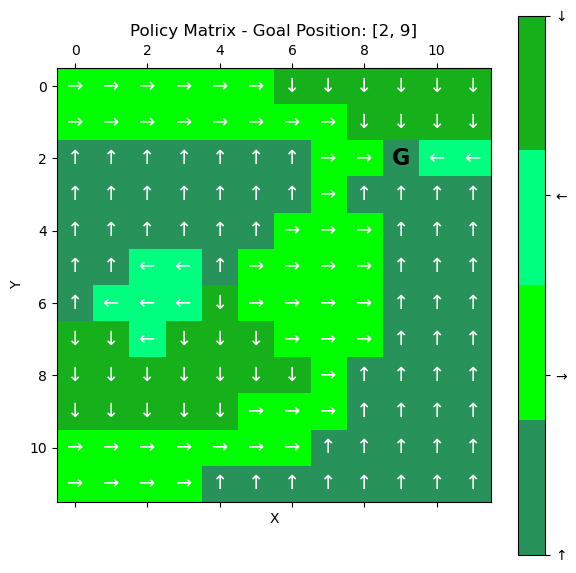

100%|██████████| 10000/10000 [00:10<00:00, 911.24it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
1           2  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
2           3  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
3           4  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
4           5  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
...       ...                                                ...   
9995     9996  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
9996     9997  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
9997     9998  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
9998     9999  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   
9999    10000  [-256.0, -51.0, -9.0, -2.0, -4.0, -9.0, -4.0, ...   

      Number of Steps  
0              3101.0  
1               970.0  
2               412.0  
3               150.0  
4               125.0  
...               ...  
9995             20.0  
9996             17.0  
9997             16.0  
9998             27.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 989.80it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
1           2  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
2           3  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
3           4  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
4           5  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
...       ...                                                ...   
9995     9996  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
9996     9997  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
9997     9998  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
9998     9999  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   
9999    10000  [-61.0, -105.0, -2.0, -16.0, -21.0, -6.0, 7.0,...   

      Number of Steps  
0              1225.0  
1              3562.0  
2               310.0  
3               294.0  
4              1152.0  
...               ...  
9995             23.0  
9996             15.0  
9997             15.0  
9998             12.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 978.54it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
1           2  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
2           3  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
3           4  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
4           5  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
...       ...                                                ...   
9995     9996  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
9996     9997  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
9997     9998  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
9998     9999  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   
9999    10000  [5.0, -17.0, -20.0, -12.0, 4.0, -41.0, 7.0, -4...   

      Number of Steps  
0               323.0  
1               452.0  
2               341.0  
3               757.0  
4              1076.0  
...               ...  
9995             20.0  
9996             17.0  
9997             16.0  
9998             24.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 966.43it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
1           2  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
2           3  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
3           4  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
4           5  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
...       ...                                                ...   
9995     9996  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
9996     9997  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
9997     9998  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
9998     9999  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   
9999    10000  [-29.0, -138.0, -74.0, 8.0, -60.0, -45.0, 8.0,...   

      Number of Steps  
0               626.0  
1              3325.0  
2              2848.0  
3                57.0  
4              2446.0  
...               ...  
9995             17.0  
9996             20.0  
9997             24.0  
9998             17.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 964.60it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
1           2  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
2           3  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
3           4  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
4           5  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
...       ...                                                ...   
9995     9996  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
9996     9997  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
9997     9998  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
9998     9999  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   
9999    10000  [-62.0, -150.0, 2.0, 9.0, -11.0, -14.0, -22.0,...   

      Number of Steps  
0               161.0  
1              2901.0  
2                59.0  
3               278.0  
4               448.0  
...               ...  
9995             24.0  
9996             20.0  
9997             17.0  
9998             30.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 973.11it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
1           2  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
2           3  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
3           4  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
4           5  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
...       ...                                                ...   
9995     9996  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
9996     9997  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
9997     9998  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
9998     9999  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   
9999    10000  [-288.0, 5.0, 0.0, -81.0, 9.0, 9.0, 9.0, 7.0, ...   

      Number of Steps  
0              3558.0  
1               549.0  
2              1513.0  
3              2294.0  
4                98.0  
...               ...  
9995             13.0  
9996             22.0  
9997             24.0  
9998             21.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1045.13it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
1           2  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
2           3  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
3           4  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
4           5  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
...       ...                                                ...   
9995     9996  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
9996     9997  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
9997     9998  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
9998     9999  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   
9999    10000  [-71.0, 7.0, -50.0, 6.0, 9.0, 8.0, 6.0, 5.0, 6...   

      Number of Steps  
0              2356.0  
1                94.0  
2              1004.0  
3                51.0  
4               282.0  
...               ...  
9995             16.0  
9996             19.0  
9997             22.0  
9998             18.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 900.33it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
1           2  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
2           3  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
3           4  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
4           5  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
...       ...                                                ...   
9995     9996  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
9996     9997  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
9997     9998  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
9998     9999  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   
9999    10000  [-41.0, -3.0, 2.0, 4.0, -29.0, -13.0, 4.0, 9.0...   

      Number of Steps  
0              1298.0  
1               362.0  
2               310.0  
3               287.0  
4               713.0  
...               ...  
9995             21.0  
9996             21.0  
9997             18.0  
9998             13.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 861.99it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
1           2  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
2           3  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
3           4  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
4           5  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
...       ...                                                ...   
9995     9996  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
9996     9997  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
9997     9998  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
9998     9999  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   
9999    10000  [-59.0, 1.0, -406.0, -76.0, 7.0, -80.0, -67.0,...   

      Number of Steps  
0               674.0  
1               163.0  
2             11147.0  
3              3370.0  
4               377.0  
...               ...  
9995             18.0  
9996             13.0  
9997             31.0  
9998             20.0  
9999             15.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 871.84it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0           1  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
1           2  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
2           3  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
3           4  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
4           5  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
...       ...                                                ...   
9995     9996  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
9996     9997  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
9997     9998  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
9998     9999  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   
9999    10000  [-146.0, -261.0, -82.0, -2.0, -2.0, 6.0, 1.0, ...   

      Number of Steps  
0              6261.0  
1              7013.0  
2              2283.0  
3               759.0  
4               294.0  
...               ...  
9995             14.0  
9996             17.0  
9997             19.0  
9998             20.0  
9999             18.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 862.74it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
1           2  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
2           3  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
3           4  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
4           5  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
...       ...                                                ...   
9995     9996  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
9996     9997  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
9997     9998  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
9998     9999  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   
9999    10000  [-8.0, -63.0, -101.0, -242.0, -35.0, 9.0, 0.0,...   

      Number of Steps  
0               773.0  
1              1502.0  
2              2668.0  
3             11717.0  
4               873.0  
...               ...  
9995             17.0  
9996             20.0  
9997             15.0  
9998             17.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1046.40it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0           1  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
1           2  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
2           3  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
3           4  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
4           5  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
...       ...                                                ...   
9995     9996  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
9996     9997  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
9997     9998  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
9998     9999  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   
9999    10000  [-266.0, -17.0, -2.0, -306.0, 8.0, 1.0, 7.0, 9...   

      Number of Steps  
0              6827.0  
1                73.0  
2               509.0  
3             13805.0  
4               113.0  
...               ...  
9995             23.0  
9996             13.0  
9997             11.0  
9998             16.0  
9999             24.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 986.68it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
1           2  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
2           3  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
3           4  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
4           5  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
...       ...                                                ...   
9995     9996  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
9996     9997  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
9997     9998  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
9998     9999  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   
9999    10000  [-177.0, -95.0, -205.0, -26.0, 0.0, -7.0, 8.0,...   

      Number of Steps  
0              2464.0  
1              1218.0  
2              8544.0  
3              2626.0  
4               789.0  
...               ...  
9995             13.0  
9996             14.0  
9997             19.0  
9998             16.0  
9999             15.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 962.00it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
1           2  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
2           3  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
3           4  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
4           5  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
...       ...                                                ...   
9995     9996  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
9996     9997  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
9997     9998  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
9998     9999  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   
9999    10000  [-108.0, -88.0, -140.0, -9.0, -26.0, 7.0, -1.0...   

      Number of Steps  
0              1291.0  
1              1952.0  
2              4078.0  
3              1421.0  
4               674.0  
...               ...  
9995             19.0  
9996             11.0  
9997             37.0  
9998             17.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1110.49it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
1           2  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
2           3  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
3           4  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
4           5  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
...       ...                                                ...   
9995     9996  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
9996     9997  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
9997     9998  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
9998     9999  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   
9999    10000  [-41.0, -71.0, -36.0, -1.0, -27.0, -20.0, 8.0,...   

      Number of Steps  
0               121.0  
1              1358.0  
2               769.0  
3               348.0  
4              1532.0  
...               ...  
9995             15.0  
9996             12.0  
9997             12.0  
9998             19.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 979.05it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
1           2  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
2           3  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
3           4  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
4           5  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
...       ...                                                ...   
9995     9996  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
9996     9997  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
9997     9998  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
9998     9999  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   
9999    10000  [-42.0, -34.0, -25.0, -44.0, -9.0, -15.0, -34....   

      Number of Steps  
0               607.0  
1               512.0  
2               244.0  
3              1106.0  
4               162.0  
...               ...  
9995             20.0  
9996             25.0  
9997             15.0  
9998             19.0  
9999             15.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 896.87it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
1           2  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
2           3  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
3           4  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
4           5  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
...       ...                                                ...   
9995     9996  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
9996     9997  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
9997     9998  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
9998     9999  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   
9999    10000  [-12.0, 0.0, -19.0, -31.0, -270.0, 1.0, -8.0, ...   

      Number of Steps  
0               993.0  
1               248.0  
2               200.0  
3               600.0  
4              5188.0  
...               ...  
9995             20.0  
9996             29.0  
9997             17.0  
9998             16.0  
9999             15.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 986.97it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
1           2  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
2           3  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
3           4  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
4           5  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
...       ...                                                ...   
9995     9996  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
9996     9997  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
9997     9998  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
9998     9999  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   
9999    10000  [-97.0, -54.0, -20.0, -3.0, -21.0, 7.0, 6.0, 6...   

      Number of Steps  
0               949.0  
1               655.0  
2               182.0  
3               238.0  
4               608.0  
...               ...  
9995             12.0  
9996             19.0  
9997             16.0  
9998             13.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 936.50it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 24.0


Episode                                         Avg Reward  \
0           1  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
1           2  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
2           3  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
3           4  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
4           5  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
...       ...                                                ...   
9995     9996  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
9996     9997  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
9997     9998  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
9998     9999  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   
9999    10000  [-341.0, -89.0, -62.0, 9.0, 7.0, 0.0, -13.0, 1...   

      Number of Steps  
0              4349.0  
1              6835.0  
2              2084.0  
3               168.0  
4               372.0  
...               ...  
9995             16.0  
9996             19.0  
9997             21.0  
9998             15.0  
9999             24.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 913.83it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
1           2  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
2           3  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
3           4  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
4           5  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
...       ...                                                ...   
9995     9996  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
9996     9997  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
9997     9998  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
9998     9999  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   
9999    10000  [-404.0, -37.0, -25.0, -47.0, -2.0, -52.0, -2....   

      Number of Steps  
0              5396.0  
1              1007.0  
2              2366.0  
3              2959.0  
4               426.0  
...               ...  
9995             21.0  
9996             15.0  
9997             13.0  
9998             18.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:08<00:00, 1117.50it/s]


-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
1           2  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
2           3  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
3           4  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
4           5  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
...       ...                                                ...   
9995     9996  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
9996     9997  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
9997     9998  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
9998     9999  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   
9999    10000  [-69.0, -153.0, -33.0, -4.0, 4.0, -12.0, 4.0, ...   

      Number of Steps  
0               552.0  
1              1457.0  
2               123.0  
3               563.0  
4               361.0  
...               ...  
9995             18.0  
9996             16.0  
9997             17.0  
9998             18.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 936.29it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
1           2  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
2           3  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
3           4  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
4           5  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
...       ...                                                ...   
9995     9996  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
9996     9997  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
9997     9998  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
9998     9999  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   
9999    10000  [-242.0, -123.0, -87.0, -4.0, 3.0, 3.0, -78.0,...   

      Number of Steps  
0              1469.0  
1              2738.0  
2              3315.0  
3               320.0  
4                88.0  
...               ...  
9995             16.0  
9996             16.0  
9997             15.0  
9998             19.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1101.69it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 12.0


Episode                                         Avg Reward  \
0           1  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
1           2  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
2           3  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
3           4  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
4           5  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
...       ...                                                ...   
9995     9996  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
9996     9997  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
9997     9998  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
9998     9999  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   
9999    10000  [-30.0, -14.0, 8.0, -40.0, 8.0, -2.0, 8.0, 9.0...   

      Number of Steps  
0               378.0  
1               247.0  
2               114.0  
3               530.0  
4                78.0  
...               ...  
9995             14.0  
9996             17.0  
9997             29.0  
9998             16.0  
9999             12.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 995.12it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 15.0


Episode                                         Avg Reward  \
0           1  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
1           2  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
2           3  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
3           4  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
4           5  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
...       ...                                                ...   
9995     9996  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
9996     9997  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
9997     9998  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
9998     9999  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   
9999    10000  [-8.0, 4.0, -120.0, 4.0, 3.0, -33.0, -25.0, -5...   

      Number of Steps  
0               575.0  
1                26.0  
2              1162.0  
3                58.0  
4               306.0  
...               ...  
9995             18.0  
9996             20.0  
9997             18.0  
9998             20.0  
9999             15.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 906.81it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
1           2  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
2           3  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
3           4  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
4           5  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
...       ...                                                ...   
9995     9996  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
9996     9997  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
9997     9998  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
9998     9999  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   
9999    10000  [-17.0, -84.0, -114.0, -103.0, 2.0, 1.0, 6.0, ...   

      Number of Steps  
0                49.0  
1               336.0  
2              1916.0  
3              2341.0  
4               264.0  
...               ...  
9995             20.0  
9996             25.0  
9997             15.0  
9998             22.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 926.70it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
1           2  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
2           3  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
3           4  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
4           5  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
...       ...                                                ...   
9995     9996  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
9996     9997  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
9997     9998  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
9998     9999  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   
9999    10000  [-85.0, -181.0, -94.0, 4.0, -35.0, -1.0, 9.0, ...   

      Number of Steps  
0               125.0  
1              1831.0  
2              1499.0  
3               126.0  
4               957.0  
...               ...  
9995             20.0  
9996             25.0  
9997             13.0  
9998             19.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 970.56it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
1           2  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
2           3  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
3           4  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
4           5  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
...       ...                                                ...   
9995     9996  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
9996     9997  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
9997     9998  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
9998     9999  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   
9999    10000  [-28.0, -2.0, -52.0, 6.0, -15.0, 2.0, -9.0, -2...   

      Number of Steps  
0              1090.0  
1              1982.0  
2               456.0  
3               302.0  
4               689.0  
...               ...  
9995             15.0  
9996             35.0  
9997             16.0  
9998             13.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 919.12it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 11.0


Episode                                         Avg Reward  \
0           1  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
1           2  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
2           3  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
3           4  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
4           5  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
...       ...                                                ...   
9995     9996  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
9996     9997  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
9997     9998  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
9998     9999  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   
9999    10000  [-4.0, -23.0, -33.0, 7.0, -33.0, 9.0, 7.0, 9.0...   

      Number of Steps  
0               876.0  
1               573.0  
2              2082.0  
3               456.0  
4              2239.0  
...               ...  
9995             18.0  
9996             28.0  
9997             17.0  
9998             17.0  
9999             11.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 988.56it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 34.0


Episode                                         Avg Reward  \
0           1  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
1           2  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
2           3  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
3           4  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
4           5  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
...       ...                                                ...   
9995     9996  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
9996     9997  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
9997     9998  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
9998     9999  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   
9999    10000  [-119.0, -22.0, 0.0, 6.0, 3.0, -13.0, 0.0, -22...   

      Number of Steps  
0              2433.0  
1              1668.0  
2               149.0  
3               168.0  
4                35.0  
...               ...  
9995             16.0  
9996             14.0  
9997             19.0  
9998             18.0  
9999             34.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 926.01it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
1           2  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
2           3  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
3           4  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
4           5  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
...       ...                                                ...   
9995     9996  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
9996     9997  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
9997     9998  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
9998     9999  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   
9999    10000  [-50.0, -52.0, 3.0, 2.0, 9.0, 4.0, 5.0, 9.0, 9...   

      Number of Steps  
0               957.0  
1              2768.0  
2               423.0  
3               116.0  
4                66.0  
...               ...  
9995             24.0  
9996             14.0  
9997             20.0  
9998             26.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1075.15it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
1           2  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
2           3  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
3           4  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
4           5  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
...       ...                                                ...   
9995     9996  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
9996     9997  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
9997     9998  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
9998     9999  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   
9999    10000  [-58.0, -110.0, -20.0, 7.0, -32.0, 4.0, 7.0, -...   

      Number of Steps  
0               826.0  
1              1851.0  
2               603.0  
3               292.0  
4              1811.0  
...               ...  
9995             20.0  
9996             15.0  
9997             25.0  
9998             24.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 974.08it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
1           2  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
2           3  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
3           4  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
4           5  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
...       ...                                                ...   
9995     9996  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
9996     9997  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
9997     9998  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
9998     9999  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   
9999    10000  [-160.0, -12.0, -6.0, -13.0, 9.0, -3.0, 6.0, -...   

      Number of Steps  
0              2896.0  
1               114.0  
2               500.0  
3               437.0  
4               423.0  
...               ...  
9995             11.0  
9996             15.0  
9997             29.0  
9998             16.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 942.50it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 21.0


Episode                                         Avg Reward  \
0           1  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
1           2  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
2           3  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
3           4  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
4           5  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
...       ...                                                ...   
9995     9996  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
9996     9997  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
9997     9998  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
9998     9999  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   
9999    10000  [-58.0, -34.0, 0.0, 3.0, 9.0, -60.0, 9.0, -19....   

      Number of Steps  
0               971.0  
1               565.0  
2               667.0  
3               133.0  
4               315.0  
...               ...  
9995             22.0  
9996             24.0  
9997             21.0  
9998             25.0  
9999             21.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 952.47it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 23.0


Episode                                         Avg Reward  \
0           1  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
1           2  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
2           3  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
3           4  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
4           5  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
...       ...                                                ...   
9995     9996  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
9996     9997  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
9997     9998  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
9998     9999  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   
9999    10000  [-9.0, -21.0, 5.0, -75.0, -35.0, -21.0, 8.0, 6...   

      Number of Steps  
0               513.0  
1                71.0  
2               283.0  
3               755.0  
4               422.0  
...               ...  
9995             13.0  
9996             18.0  
9997             30.0  
9998             18.0  
9999             23.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 926.70it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 7.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
1           2  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
2           3  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
3           4  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
4           5  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
...       ...                                                ...   
9995     9996  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
9996     9997  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
9997     9998  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
9998     9999  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   
9999    10000  [-22.0, -47.0, -38.0, -93.0, -15.0, 1.0, -4.0,...   

      Number of Steps  
0               249.0  
1               624.0  
2               246.0  
3              1386.0  
4               248.0  
...               ...  
9995             16.0  
9996             11.0  
9997             35.0  
9998             22.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1042.21it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 26.0


Episode                                         Avg Reward  \
0           1  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
1           2  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
2           3  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
3           4  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
4           5  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
...       ...                                                ...   
9995     9996  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
9996     9997  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
9997     9998  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
9998     9999  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   
9999    10000  [1.0, -68.0, 9.0, -21.0, -10.0, -38.0, 3.0, 1....   

      Number of Steps  
0               812.0  
1              3924.0  
2               142.0  
3               625.0  
4               678.0  
...               ...  
9995             33.0  
9996             29.0  
9997             18.0  
9998             16.0  
9999             26.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 966.09it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 5.0, Number of steps = 20.0


Episode                                         Avg Reward  \
0           1  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
1           2  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
2           3  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
3           4  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
4           5  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
...       ...                                                ...   
9995     9996  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
9996     9997  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
9997     9998  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
9998     9999  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   
9999    10000  [-44.0, -6.0, -30.0, -67.0, 5.0, 6.0, 5.0, -6....   

      Number of Steps  
0               816.0  
1               240.0  
2               169.0  
3              2175.0  
4               186.0  
...               ...  
9995             26.0  
9996             15.0  
9997             22.0  
9998             18.0  
9999             20.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 908.58it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 22.0


Episode                                         Avg Reward  \
0           1  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
1           2  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
2           3  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
3           4  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
4           5  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
...       ...                                                ...   
9995     9996  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
9996     9997  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
9997     9998  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
9998     9999  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   
9999    10000  [-40.0, -86.0, -12.0, 8.0, -1.0, -74.0, -4.0, ...   

      Number of Steps  
0               257.0  
1              3403.0  
2               565.0  
3               304.0  
4               558.0  
...               ...  
9995             27.0  
9996             26.0  
9997             29.0  
9998             17.0  
9999             22.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:12<00:00, 826.13it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0           1  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
1           2  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
2           3  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
3           4  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
4           5  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
...       ...                                                ...   
9995     9996  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
9996     9997  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
9997     9998  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
9998     9999  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   
9999    10000  [-39.0, -466.0, -77.0, -46.0, -4.0, 6.0, 9.0, ...   

      Number of Steps  
0              1246.0  
1             20071.0  
2              4333.0  
3              4020.0  
4              2396.0  
...               ...  
9995             25.0  
9996             23.0  
9997             18.0  
9998             15.0  
9999             27.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 900.84it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 14.0


Episode                                         Avg Reward  \
0           1  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
1           2  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
2           3  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
3           4  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
4           5  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
...       ...                                                ...   
9995     9996  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
9996     9997  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
9997     9998  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
9998     9999  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   
9999    10000  [-22.0, -30.0, 6.0, -38.0, -22.0, -36.0, -119....   

      Number of Steps  
0               513.0  
1              1019.0  
2               824.0  
3               155.0  
4              1207.0  
...               ...  
9995             13.0  
9996             23.0  
9997             18.0  
9998             19.0  
9999             14.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1009.57it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
1           2  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
2           3  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
3           4  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
4           5  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
...       ...                                                ...   
9995     9996  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
9996     9997  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
9997     9998  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
9998     9999  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   
9999    10000  [6.0, -3.0, 2.0, 7.0, 9.0, -133.0, 6.0, 8.0, -...   

      Number of Steps  
0               358.0  
1               588.0  
2               723.0  
3               168.0  
4               190.0  
...               ...  
9995             17.0  
9996             37.0  
9997             18.0  
9998             15.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 906.37it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 3.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0           1  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
1           2  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
2           3  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
3           4  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
4           5  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
...       ...                                                ...   
9995     9996  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
9996     9997  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
9997     9998  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
9998     9999  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   
9999    10000  [-140.0, -9.0, -39.0, -15.0, -61.0, -42.0, -94...   

      Number of Steps  
0              2069.0  
1               118.0  
2              1443.0  
3              1911.0  
4              3627.0  
...               ...  
9995             20.0  
9996             14.0  
9997             25.0  
9998             15.0  
9999             18.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:11<00:00, 863.25it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 19.0


Episode                                         Avg Reward  \
0           1  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
1           2  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
2           3  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
3           4  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
4           5  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
...       ...                                                ...   
9995     9996  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
9996     9997  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
9997     9998  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
9998     9999  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   
9999    10000  [-11.0, -18.0, 9.0, -15.0, 7.0, -18.0, -1.0, -...   

      Number of Steps  
0              1261.0  
1               386.0  
2               153.0  
3               240.0  
4               299.0  
...               ...  
9995             15.0  
9996             14.0  
9997             15.0  
9998             19.0  
9999             19.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:13<00:00, 760.80it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 6.0, Number of steps = 16.0


Episode                                         Avg Reward  \
0           1  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
1           2  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
2           3  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
3           4  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
4           5  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
...       ...                                                ...   
9995     9996  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
9996     9997  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
9997     9998  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
9998     9999  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   
9999    10000  [-71.0, -25.0, -74.0, -282.0, -117.0, -162.0, ...   

      Number of Steps  
0              1139.0  
1               897.0  
2              4578.0  
3              9495.0  
4              8801.0  
...               ...  
9995             13.0  
9996             17.0  
9997             29.0  
9998             11.0  
9999             16.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:09<00:00, 1061.57it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
1           2  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
2           3  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
3           4  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
4           5  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
...       ...                                                ...   
9995     9996  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
9996     9997  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
9997     9998  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
9998     9999  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   
9999    10000  [9.0, -1.0, -167.0, -7.0, 3.0, 4.0, -8.0, 7.0,...   

      Number of Steps  
0               240.0  
1                71.0  
2              1066.0  
3               533.0  
4               485.0  
...               ...  
9995             17.0  
9996             22.0  
9997             17.0  
9998             18.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 999.87it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 17.0


Episode                                         Avg Reward  \
0           1  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
1           2  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
2           3  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
3           4  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
4           5  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
...       ...                                                ...   
9995     9996  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
9996     9997  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
9997     9998  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
9998     9999  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   
9999    10000  [-180.0, -428.0, 3.0, -53.0, 0.0, -3.0, -12.0,...   

      Number of Steps  
0              1498.0  
1             13251.0  
2               227.0  
3              3854.0  
4               675.0  
...               ...  
9995             13.0  
9996             18.0  
9997             21.0  
9998             19.0  
9999             17.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 929.67it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 18.0


Episode                                         Avg Reward  \
0           1  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
1           2  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
2           3  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
3           4  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
4           5  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
...       ...                                                ...   
9995     9996  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
9996     9997  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
9997     9998  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
9998     9999  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   
9999    10000  [-251.0, -35.0, -20.0, 6.0, 9.0, -35.0, -7.0, ...   

      Number of Steps  
0              7289.0  
1              3407.0  
2              1296.0  
3               452.0  
4                69.0  
...               ...  
9995             17.0  
9996             20.0  
9997             15.0  
9998             22.0  
9999             18.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 912.48it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 13.0


Episode                                         Avg Reward  \
0           1  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
1           2  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
2           3  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
3           4  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
4           5  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
...       ...                                                ...   
9995     9996  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
9996     9997  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
9997     9998  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
9998     9999  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   
9999    10000  [-59.0, -29.0, -52.0, -4.0, -48.0, -12.0, 4.0,...   

      Number of Steps  
0               284.0  
1                57.0  
2               874.0  
3               175.0  
4               139.0  
...               ...  
9995             17.0  
9996             20.0  
9997             13.0  
9998             24.0  
9999             13.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 986.39it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 9.0, Number of steps = 31.0


Episode                                         Avg Reward  \
0           1  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
1           2  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
2           3  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
3           4  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
4           5  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
...       ...                                                ...   
9995     9996  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
9996     9997  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
9997     9998  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
9998     9999  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   
9999    10000  [-125.0, -11.0, -4.0, -32.0, 9.0, 7.0, -14.0, ...   

      Number of Steps  
0                84.0  
1               209.0  
2              1039.0  
3               752.0  
4               227.0  
...               ...  
9995             19.0  
9996             15.0  
9997             21.0  
9998             16.0  
9999             31.0  

[10000 rows x 3 columns]

100%|██████████| 10000/10000 [00:10<00:00, 928.25it/s]

-----------All episodes done-----------
Episode 10000: Total reward = 8.0, Number of steps = 27.0


Episode                                         Avg Reward  \
0           1  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
1           2  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
2           3  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
3           4  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
4           5  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
...       ...                                                ...   
9995     9996  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
9996     9997  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
9997     9998  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
9998     9999  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   
9999    10000  [3.0, -229.0, 7.0, 8.0, -96.0, 8.0, -23.0, 1.0...   

      Number of Steps  
0               213.0  
1              6467.0  
2               747.0  
3               347.0  
4              2710.0  
...               ...  
9995             24.0  
9996             24.0  
9997             15.0  
9998             16.0  
9999             27.0  

[10000 rows x 3 columns]

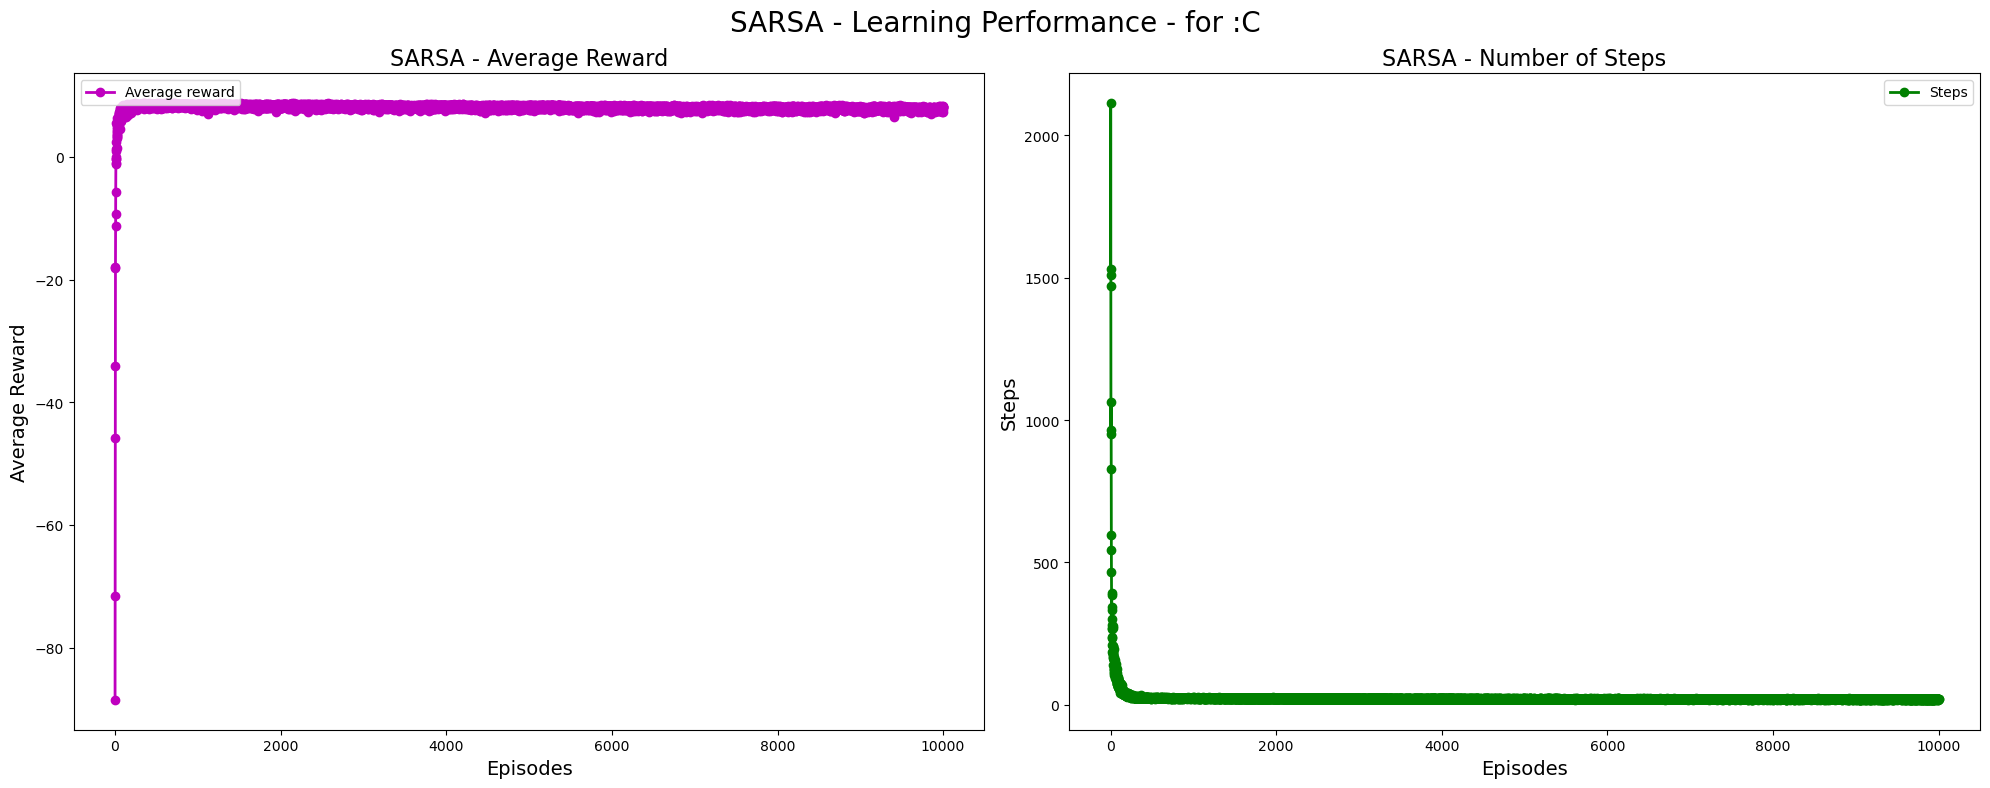

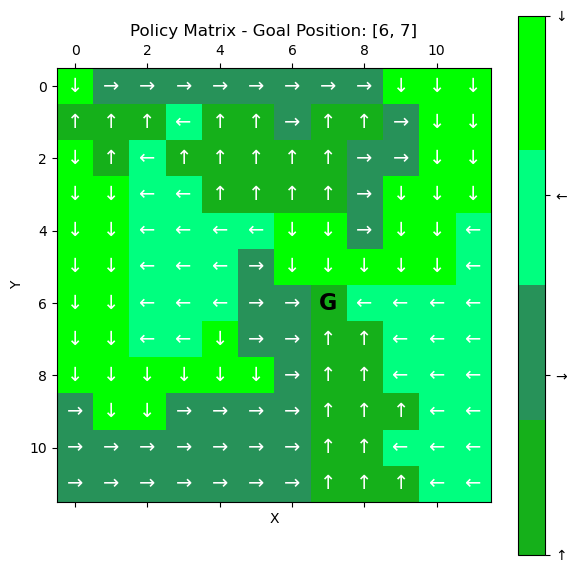

In [13]:
for goal_SARSA in ['A', 'B', 'C']:
    # Get the goal position from the goal_positions dictionary
    goal_pos_SARSA = goal_positions.get(goal_SARSA, [0, 11])
    
    # Run 50 independent SARSA run
    episode_data_list_SARSA = []

    for _ in range(independent_run):
        avg_reward, steps, Q = algo_object_SARSA.episode_run(gamma, alpha, epsilon, episodes, PuddleWorld(), goal_SARSA)
        episode_data_list_SARSA.append((avg_reward, steps, Q))

    # Calculate the average rewards and average steps over the 50 runs
    avg_rewards_SARSA, avg_steps_SARSA = np.zeros([episodes]),np.zeros([episodes])
    
    for i in range(episodes):
        for j in range(len(episode_data_list_SARSA)):
            avg_rewards_SARSA[i] += episode_data_list_SARSA[j][0][i]/len(episode_data_list_SARSA)
            avg_steps_SARSA[i] += episode_data_list_SARSA[j][1][i]/len(episode_data_list_SARSA)

    # Calculate the policy matrix based on the most common action in each state
    policy_matrix_SARSA = np.zeros([12, 12])
    action_counts_SARSA = {0: 0, 1: 0, 2: 0, 3: 0}
    for i in range(12):
        for j in range(12):
            for k in range(len(episode_data_list_SARSA)):
                action_counts_SARSA[np.argmax(episode_data_list_SARSA[k][2], axis=SARSA_axis)[i, j]] += 1
            max_action_SARSA = max(action_counts_SARSA, key=action_counts_SARSA.get)
            action_counts_SARSA = {0: 0, 1: 0, 2: 0, 3: 0}
            policy_matrix_SARSA[i, j] = max_action_SARSA

    # Plot the reward and steps per episode for the current goal using SARSA
    plot_reward_steps(avg_rewards_SARSA, avg_steps_SARSA, episodes, 'SARSA', goal_SARSA)

    # Plot the policy matrix for the current goal using SARSA
    plot_policy(goal_pos_SARSA, policy_matrix_SARSA)

In [14]:
end_time= time.time()

#### Execution Time 

In [15]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 8846.40 seconds


##### Analysis : 
    - 1. Upon an in-depth analysis of our implementation of Q-Learning and SARSA for the Puddle World problem, it is apparent that both algorithms deliver robust performances. Both approaches display evolving optimal policies that vary according to each run and random seed, reflecting the inherent dynamism of reinforcement learning algorithms.

    - 2. However, when we scrutinize the scenarios from a broader perspective, Q-Learning demonstrates a slight edge over SARSA in a subset of iterations and for certain random seeds. This pattern is a testament to the unique attributes of the Q-Learning algorithm and its slightly superior efficacy under these particular circumstances. Yet, it is crucial to consider the environment and the specificities of the problem at hand when choosing between these two reinforcement learning methods.
    
    
##### Conclusion : In conclusion, both Q-Learning and SARSA have shown their effectiveness in solving the Puddle World problem, with each showcasing their strengths under different conditions. This study further underscores the importance of careful algorithm selection in reinforcement learning to best match the nature and requirements of the problem.